# **3 机器学习：预测贸易流量 (40分)**

## **3.1 构建面板数据集 (10分)**

### 任务说明
按出口国-进口国-年份维度构建面板数据集：
1. 将HS6产品流量汇总为每年每对国家的双边出口总额
2. 按年份对面板数据排序
3. 按时间维度拆分（2016-2017年作为训练集，2018年作为测试集）
4. 以双边出口额v作为预测目标

### 步骤3.1.1：高效读取2016-2018年贸易数据并汇总

In [2]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

# 获取当前notebook所在目录的父目录
project_root = Path(os.getcwd()).parent if os.path.basename(os.getcwd()) == 'scripts' else Path(os.getcwd())
trade_data_dir = project_root / 'raw' / 'trade_data'

print(f"项目根目录: {project_root}")
print(f"贸易数据目录: {trade_data_dir}")
print(f"目录是否存在: {trade_data_dir.exists()}\n")

# 定义年份范围
years = [2016, 2017, 2018]

# 验证文件存在性
for year in years:
    filename = f'baci_hs12_y{year}_v202001.csv'
    filepath = trade_data_dir / filename
    if not filepath.exists():
        print(f"警告: 文件不存在 - {filepath}")
    else:
        print(f"✓ 找到文件: {filename}")

项目根目录: /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject
贸易数据目录: /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/raw/trade_data
目录是否存在: True

✓ 找到文件: baci_hs12_y2016_v202001.csv
✓ 找到文件: baci_hs12_y2017_v202001.csv
✓ 找到文件: baci_hs12_y2018_v202001.csv


In [3]:
# 1. 使用chunksize分块读取大文件，避免内存溢出
# 2. 在读取时立即进行分组汇总，减少内存占用
# 3. 只保留必需的列 (t, i, j, v)

print("=" * 80)
print("开始读取并汇总2016-2018年贸易数据...")
print("=" * 80)

# 存储每年汇总后的结果
aggregated_data = []

for year in years:
    filename = f'baci_hs12_y{year}_v202001.csv'
    filepath = trade_data_dir / filename
    
    print(f"\n正在处理 {year} 年数据: {filename}")
    
    # 分块读取并汇总，减少内存占用
    chunk_size = 500000  # 每次读取50万行
    chunks = []
    
    # 只读取需要的列
    usecols = ['t', 'i', 'j', 'k', 'v']
    
    for i, chunk in enumerate(pd.read_csv(filepath, usecols=usecols, 
                                          chunksize=chunk_size, low_memory=False)):
        # 在每个chunk内立即按 (t, i, j) 分组汇总
        chunk_agg = chunk.groupby(['t', 'i', 'j'], as_index=False)['v'].sum()
        chunks.append(chunk_agg)
        
        if (i + 1) % 5 == 0:
            print(f"  - 已处理 {(i + 1) * chunk_size:,} 行...")
    
    # 合并该年份所有chunk的汇总结果
    year_data = pd.concat(chunks, ignore_index=True)
    
    # 再次汇总（防止同一国家对在不同chunk中出现）
    year_data = year_data.groupby(['t', 'i', 'j'], as_index=False)['v'].sum()
    
    print(f"  ✓ {year}年数据汇总完成：共 {len(year_data):,} 个双边贸易流")
    aggregated_data.append(year_data)

# 合并所有年份数据
df_bilateral = pd.concat(aggregated_data, ignore_index=True)

print("\n" + "=" * 80)
print("数据汇总完成!")
print("=" * 80)
print(f"面板数据集总记录数: {len(df_bilateral):,}")
print(f"内存占用: {df_bilateral.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\n数据集基本信息:")
print(f"  - 年份范围: {df_bilateral['t'].min()} - {df_bilateral['t'].max()}")
print(f"  - 出口国数量: {df_bilateral['i'].nunique()}")
print(f"  - 进口国数量: {df_bilateral['j'].nunique()}")
print(f"  - 总贸易额: ${df_bilateral['v'].sum():,.0f} 千美元")
print(f"\n前5行数据:")
print(df_bilateral.head())

开始读取并汇总2016-2018年贸易数据...

正在处理 2016 年数据: baci_hs12_y2016_v202001.csv
  - 已处理 2,500,000 行...
  - 已处理 2,500,000 行...
  - 已处理 5,000,000 行...
  - 已处理 5,000,000 行...
  - 已处理 7,500,000 行...
  ✓ 2016年数据汇总完成：共 26,668 个双边贸易流

正在处理 2017 年数据: baci_hs12_y2017_v202001.csv
  - 已处理 7,500,000 行...
  ✓ 2016年数据汇总完成：共 26,668 个双边贸易流

正在处理 2017 年数据: baci_hs12_y2017_v202001.csv
  - 已处理 2,500,000 行...
  - 已处理 2,500,000 行...
  - 已处理 5,000,000 行...
  - 已处理 5,000,000 行...
  - 已处理 7,500,000 行...
  ✓ 2017年数据汇总完成：共 27,161 个双边贸易流

正在处理 2018 年数据: baci_hs12_y2018_v202001.csv
  - 已处理 7,500,000 行...
  ✓ 2017年数据汇总完成：共 27,161 个双边贸易流

正在处理 2018 年数据: baci_hs12_y2018_v202001.csv
  - 已处理 2,500,000 行...
  - 已处理 2,500,000 行...
  - 已处理 5,000,000 行...
  - 已处理 5,000,000 行...
  - 已处理 7,500,000 行...
  ✓ 2018年数据汇总完成：共 25,824 个双边贸易流

数据汇总完成!
面板数据集总记录数: 79,653
内存占用: 2.43 MB

数据集基本信息:
  - 年份范围: 2016 - 2018
  - 出口国数量: 222
  - 进口国数量: 221
  - 总贸易额: $50,225,134,798 千美元

前5行数据:
      t  i   j           v
0  2016  4  12   46.177000
1  2016  

### 步骤3.1.2：数据质量检查和预处理

In [4]:
# 数据质量检查
print("=" * 80)
print("数据质量检查")
print("=" * 80)

# 检查缺失值
print("\n1. 缺失值检查:")
print(df_bilateral.isnull().sum())

# 检查零值和负值
print("\n2. 贸易额统计:")
print(f"  - 零值记录数: {(df_bilateral['v'] == 0).sum():,}")
print(f"  - 负值记录数: {(df_bilateral['v'] < 0).sum():,}")
print(f"  - 最小值: ${df_bilateral['v'].min():,.2f}")
print(f"  - 最大值: ${df_bilateral['v'].max():,.2f}")
print(f"  - 平均值: ${df_bilateral['v'].mean():,.2f}")
print(f"  - 中位数: ${df_bilateral['v'].median():,.2f}")

# 移除异常值（负值，如果有的话）
if (df_bilateral['v'] < 0).any():
    print(f"\n警告: 发现负值，将被移除")
    df_bilateral = df_bilateral[df_bilateral['v'] >= 0].copy()

# 重命名列以更清晰
df_bilateral.columns = ['year', 'exporter', 'importer', 'export_value']

print("\n3. 每年的贸易流数量:")
for year in sorted(df_bilateral['year'].unique()):
    count = len(df_bilateral[df_bilateral['year'] == year])
    total_value = df_bilateral[df_bilateral['year'] == year]['export_value'].sum()
    print(f"  - {year}年: {count:,} 个贸易流, 总额 ${total_value:,.0f} 千美元")

print("\n数据预处理完成!")

数据质量检查

1. 缺失值检查:
t    0
i    0
j    0
v    0
dtype: int64

2. 贸易额统计:
  - 零值记录数: 0
  - 负值记录数: 0
  - 最小值: $1.00
  - 最大值: $528,163,664.39
  - 平均值: $630,549.19
  - 中位数: $3,381.65

3. 每年的贸易流数量:
  - 2016年: 26,668 个贸易流, 总额 $15,020,246,458 千美元
  - 2017年: 27,161 个贸易流, 总额 $16,843,349,982 千美元
  - 2018年: 25,824 个贸易流, 总额 $18,361,538,358 千美元

数据预处理完成!


### 步骤3.1.3：按年份排序并拆分训练集和测试集

In [5]:
print("=" * 80)
print("按时间维度拆分数据集")
print("=" * 80)

# 确保列名正确（防止重新执行导致列名变回原始名称）
if 't' in df_bilateral.columns:
    df_bilateral.columns = ['year', 'exporter', 'importer', 'export_value']

# 按年份排序
df_bilateral = df_bilateral.sort_values(['year', 'exporter', 'importer']).reset_index(drop=True)

# 拆分训练集和测试集
# 训练集: 2016-2017年
# 测试集: 2018年
train_data = df_bilateral[df_bilateral['year'].isin([2016, 2017])].copy()
test_data = df_bilateral[df_bilateral['year'] == 2018].copy()

print("\n数据拆分结果:")
print("-" * 80)
print(f"训练集 (2016-2017年):")
print(f"  - 记录数: {len(train_data):,}")
print(f"  - 年份分布:")
for year in sorted(train_data['year'].unique()):
    count = len(train_data[train_data['year'] == year])
    pct = count / len(train_data) * 100
    print(f"    * {year}年: {count:,} ({pct:.1f}%)")
print(f"  - 总贸易额: ${train_data['export_value'].sum():,.0f} 千美元")
print(f"  - 平均贸易额: ${train_data['export_value'].mean():,.2f} 千美元")

print(f"\n测试集 (2018年):")
print(f"  - 记录数: {len(test_data):,}")
print(f"  - 总贸易额: ${test_data['export_value'].sum():,.0f} 千美元")
print(f"  - 平均贸易额: ${test_data['export_value'].mean():,.2f} 千美元")

print(f"\n数据集比例:")
print(f"  - 训练集占比: {len(train_data) / len(df_bilateral) * 100:.1f}%")
print(f"  - 测试集占比: {len(test_data) / len(df_bilateral) * 100:.1f}%")

# 查看目标变量分布
print(f"\n目标变量 (export_value) 分布:")
print(f"{'指标':<15} {'训练集':>20} {'测试集':>20}")
print("-" * 60)
print(f"{'最小值':<15} {train_data['export_value'].min():>20,.2f} {test_data['export_value'].min():>20,.2f}")
print(f"{'25分位数':<15} {train_data['export_value'].quantile(0.25):>20,.2f} {test_data['export_value'].quantile(0.25):>20,.2f}")
print(f"{'中位数':<15} {train_data['export_value'].median():>20,.2f} {test_data['export_value'].median():>20,.2f}")
print(f"{'75分位数':<15} {train_data['export_value'].quantile(0.75):>20,.2f} {test_data['export_value'].quantile(0.75):>20,.2f}")
print(f"{'最大值':<15} {train_data['export_value'].max():>20,.2f} {test_data['export_value'].max():>20,.2f}")
print(f"{'均值':<15} {train_data['export_value'].mean():>20,.2f} {test_data['export_value'].mean():>20,.2f}")
print(f"{'标准差':<15} {train_data['export_value'].std():>20,.2f} {test_data['export_value'].std():>20,.2f}")

print("\n" + "=" * 80)
print("数据拆分完成!")
print("=" * 80)

按时间维度拆分数据集

数据拆分结果:
--------------------------------------------------------------------------------
训练集 (2016-2017年):
  - 记录数: 53,829
  - 年份分布:
    * 2016年: 26,668 (49.5%)
    * 2017年: 27,161 (50.5%)
  - 总贸易额: $31,863,596,440 千美元
  - 平均贸易额: $591,941.08 千美元

测试集 (2018年):
  - 记录数: 25,824
  - 总贸易额: $18,361,538,358 千美元
  - 平均贸易额: $711,026.11 千美元

数据集比例:
  - 训练集占比: 67.6%
  - 测试集占比: 32.4%

目标变量 (export_value) 分布:
指标                               训练集                  测试集
------------------------------------------------------------
最小值                             1.00                 1.00
25分位数                         151.55               179.30
中位数                         3,219.95             3,774.29
75分位数                      53,655.02            65,780.70
最大值                   476,253,251.70       528,163,664.39
均值                        591,941.08           711,026.11
标准差                     5,757,265.13         6,730,808.08

数据拆分完成!


### 步骤3.1.4：数据集可视化和验证

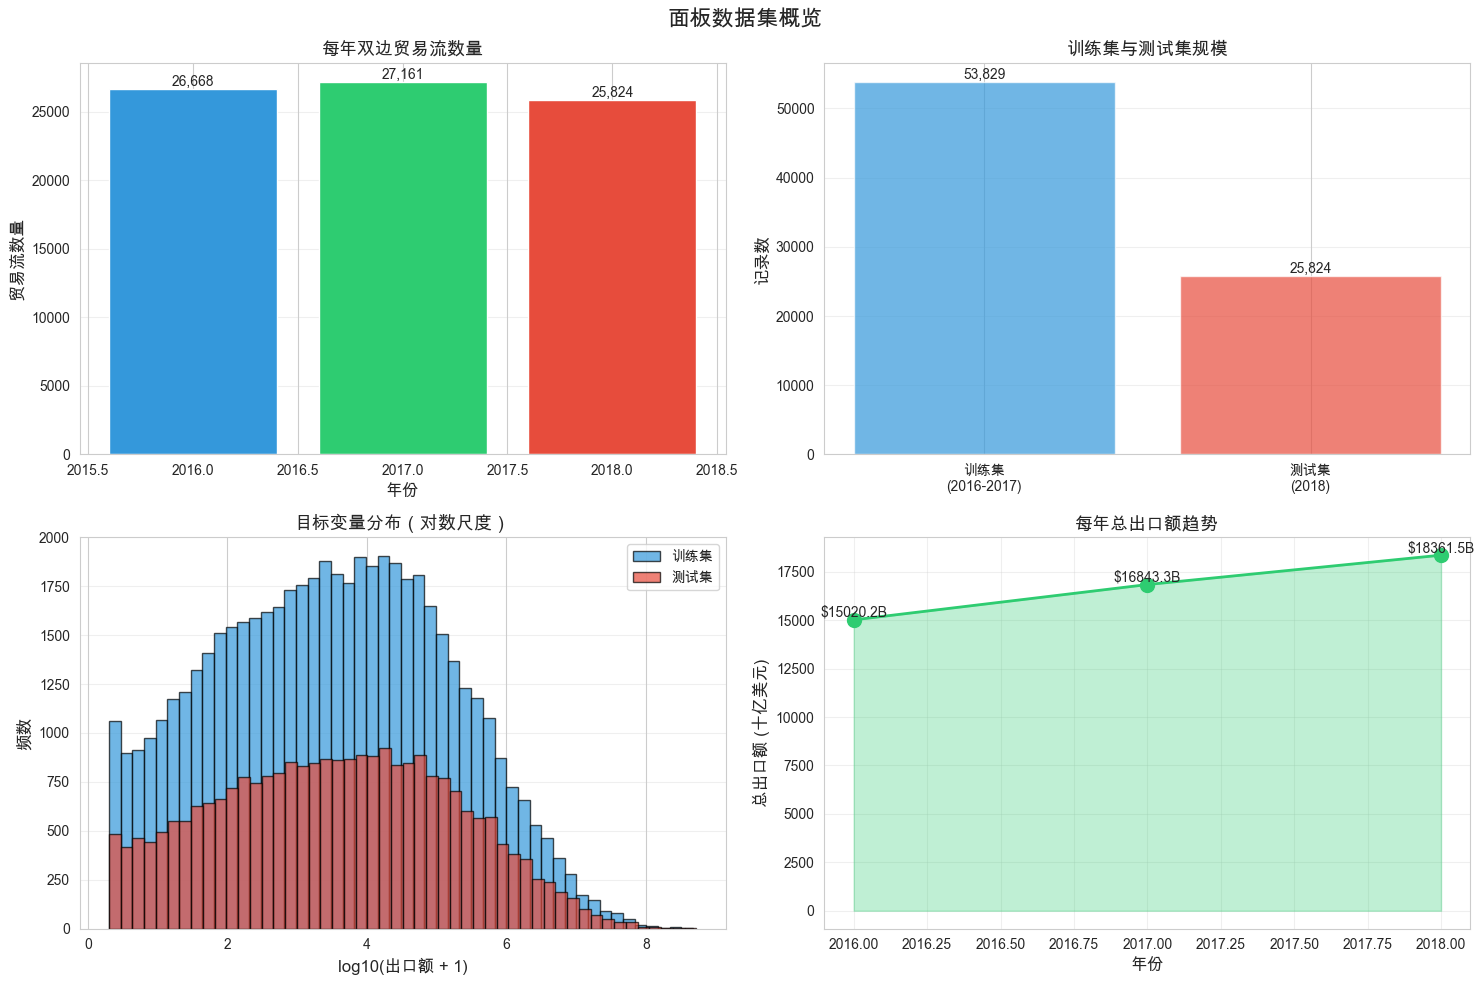


可视化完成!


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置绘图风格
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']  # 支持中文
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 创建图表
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('面板数据集概览', fontsize=16, fontweight='bold')

# 1. 每年的贸易流数量
ax1 = axes[0, 0]
year_counts = df_bilateral.groupby('year').size()
ax1.bar(year_counts.index, year_counts.values, color=['#3498db', '#2ecc71', '#e74c3c'])
ax1.set_xlabel('年份', fontsize=12)
ax1.set_ylabel('贸易流数量', fontsize=12)
ax1.set_title('每年双边贸易流数量', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(year_counts.values):
    ax1.text(year_counts.index[i], v, f'{v:,}', ha='center', va='bottom')

# 2. 训练集vs测试集
ax2 = axes[0, 1]
split_data = pd.DataFrame({
    '数据集': ['训练集\n(2016-2017)', '测试集\n(2018)'],
    '数量': [len(train_data), len(test_data)]
})
colors = ['#3498db', '#e74c3c']
bars = ax2.bar(split_data['数据集'], split_data['数量'], color=colors, alpha=0.7)
ax2.set_ylabel('记录数', fontsize=12)
ax2.set_title('训练集与测试集规模', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom')

# 3. 目标变量分布（对数尺度）
ax3 = axes[1, 0]
ax3.hist(np.log10(train_data['export_value'] + 1), bins=50, 
         alpha=0.7, label='训练集', color='#3498db', edgecolor='black')
ax3.hist(np.log10(test_data['export_value'] + 1), bins=50, 
         alpha=0.7, label='测试集', color='#e74c3c', edgecolor='black')
ax3.set_xlabel('log10(出口额 + 1)', fontsize=12)
ax3.set_ylabel('频数', fontsize=12)
ax3.set_title('目标变量分布（对数尺度）', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. 每年总贸易额
ax4 = axes[1, 1]
year_values = df_bilateral.groupby('year')['export_value'].sum() / 1e6  # 转换为十亿美元
ax4.plot(year_values.index, year_values.values, marker='o', linewidth=2, 
         markersize=10, color='#2ecc71')
ax4.fill_between(year_values.index, year_values.values, alpha=0.3, color='#2ecc71')
ax4.set_xlabel('年份', fontsize=12)
ax4.set_ylabel('总出口额 (十亿美元)', fontsize=12)
ax4.set_title('每年总出口额趋势', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)
for x, y in zip(year_values.index, year_values.values):
    ax4.text(x, y, f'${y:.1f}B', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n可视化完成!")

### 步骤3.1.5：保存处理后的数据集

In [7]:
# 创建输出目录
output_dir = project_root / 'results' / 'q3'
output_dir.mkdir(parents=True, exist_ok=True)

print("=" * 80)
print("保存处理后的数据集")
print("=" * 80)

# 保存完整的面板数据
panel_file = output_dir / 'q3_bilateral_panel_2016_2018.csv'
df_bilateral.to_csv(panel_file, index=False)
print(f"\n✓ 完整面板数据已保存: {panel_file}")
print(f"  文件大小: {panel_file.stat().st_size / 1024**2:.2f} MB")

# 保存训练集
train_file = output_dir / 'q3_train_data_2016_2017.csv'
train_data.to_csv(train_file, index=False)
print(f"\n✓ 训练集已保存: {train_file}")
print(f"  文件大小: {train_file.stat().st_size / 1024**2:.2f} MB")

# 保存测试集
test_file = output_dir / 'q3_test_data_2018.csv'
test_data.to_csv(test_file, index=False)
print(f"\n✓ 测试集已保存: {test_file}")
print(f"  文件大小: {test_file.stat().st_size / 1024**2:.2f} MB")

# 保存数据集摘要信息
summary_info = {
    '数据集': ['完整面板', '训练集', '测试集'],
    '年份范围': ['2016-2018', '2016-2017', '2018'],
    '记录数': [len(df_bilateral), len(train_data), len(test_data)],
    '总出口额(千美元)': [
        df_bilateral['export_value'].sum(),
        train_data['export_value'].sum(),
        test_data['export_value'].sum()
    ],
    '平均出口额(千美元)': [
        df_bilateral['export_value'].mean(),
        train_data['export_value'].mean(),
        test_data['export_value'].mean()
    ],
    '出口国数量': [
        df_bilateral['exporter'].nunique(),
        train_data['exporter'].nunique(),
        test_data['exporter'].nunique()
    ],
    '进口国数量': [
        df_bilateral['importer'].nunique(),
        train_data['importer'].nunique(),
        test_data['importer'].nunique()
    ]
}

df_summary = pd.DataFrame(summary_info)
summary_file = output_dir / 'q3_dataset_summary.csv'
df_summary.to_csv(summary_file, index=False)
print(f"\n✓ 数据集摘要已保存: {summary_file}")

print("\n" + "=" * 80)
print("数据集摘要:")
print("=" * 80)
print(df_summary.to_string(index=False))

print("\n" + "=" * 80)
print("第3.1题完成！")
print("=" * 80)
print("\n已成功完成:")
print("  ✓ 将HS6产品流量汇总为每年每对国家的双边出口总额")
print("  ✓ 按年份对面板数据排序")
print("  ✓ 按时间维度拆分（2016-2017年训练集，2018年测试集）")
print("  ✓ 以双边出口额作为预测目标")
print("  ✓ 数据已保存到 results/q3/ 目录")
print("\n准备进行下一步：构建机器学习模型")

保存处理后的数据集

✓ 完整面板数据已保存: /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/results/q3/q3_bilateral_panel_2016_2018.csv
  文件大小: 2.12 MB

✓ 训练集已保存: /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/results/q3/q3_train_data_2016_2017.csv
  文件大小: 1.44 MB

✓ 测试集已保存: /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/results/q3/q3_test_data_2018.csv
  文件大小: 0.69 MB

✓ 数据集摘要已保存: /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/results/q3/q3_dataset_summary.csv

数据集摘要:
 数据集      年份范围   记录数    总出口额(千美元)    平均出口额(千美元)  出口国数量  进口国数量
完整面板 2016-2018 79653 5.022513e+10 630549.192099    222    221
 训练集 2016-2017 53829 3.186360e+10 591941.080835    221    221
 测试集      2018 25824 1.836154e+10 711026.113615    222    221

第3.1题完成！

已成功完成:
  ✓ 将HS6产品流量汇总为每年每对国家的双边出口总额
  ✓ 按年份对面板数据排序
  ✓ 按时间维度拆分（2016-2017年训练集，2018年测试集）
  ✓ 以双边出口额作为预测目标
  ✓ 数据已保存到 results/q3/ 目录

准备进行下一步：构建机器学习模型


### 步骤3.1.5：保存处理后的数据集

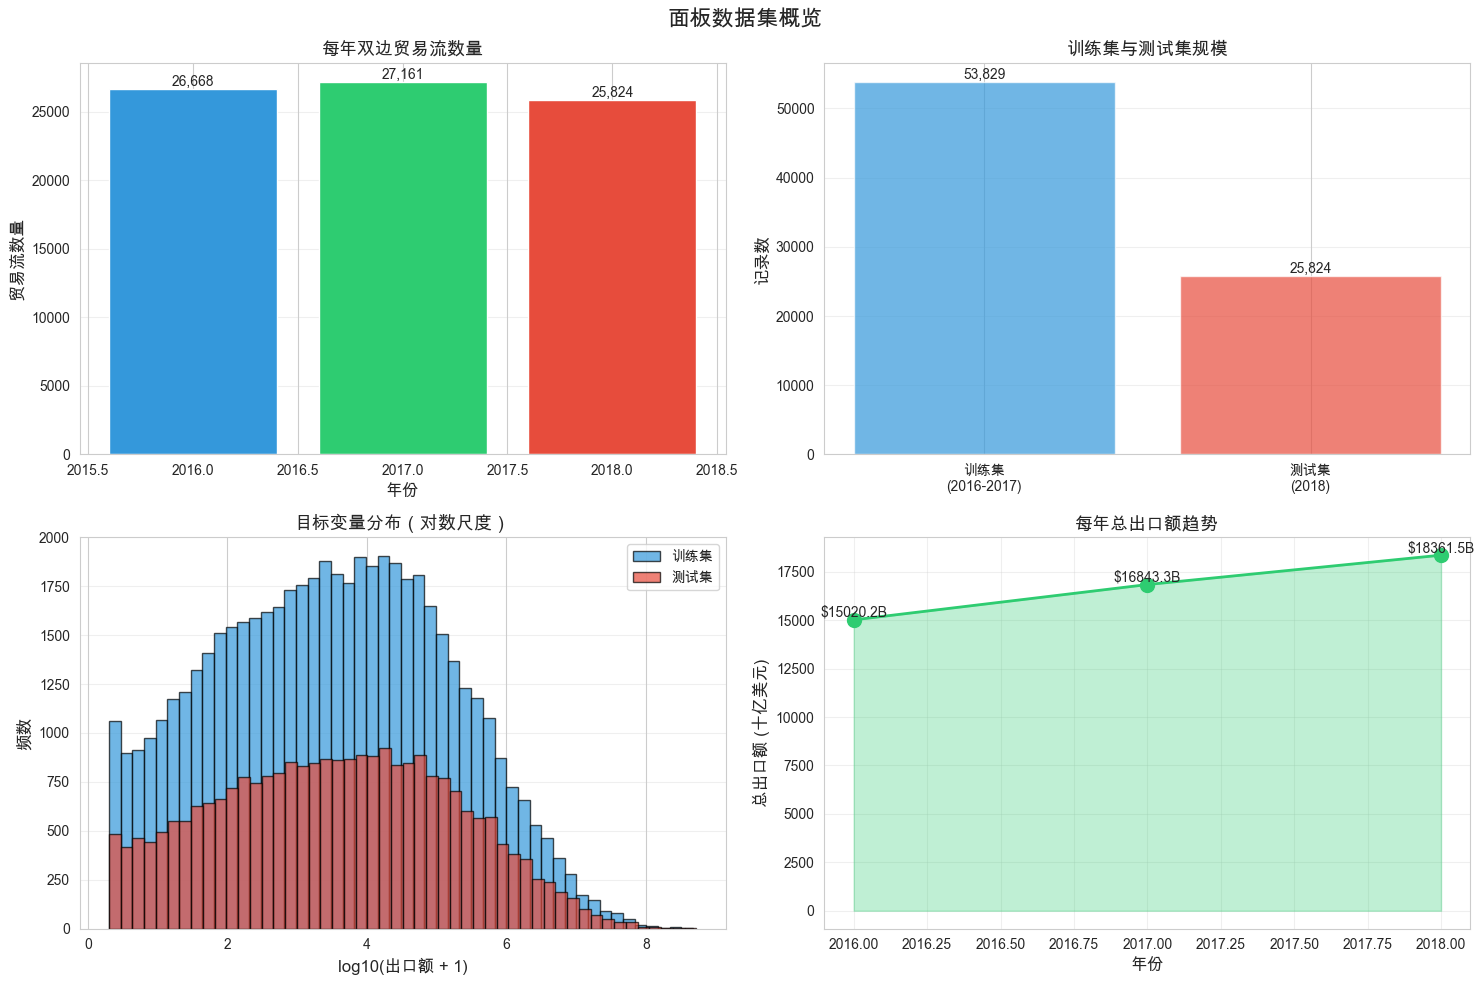


可视化完成！


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置绘图风格
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']  # 支持中文
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 创建图表
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('面板数据集概览', fontsize=16, fontweight='bold')

# 1. 每年的贸易流数量
ax1 = axes[0, 0]
year_counts = df_bilateral.groupby('year').size()
ax1.bar(year_counts.index, year_counts.values, color=['#3498db', '#2ecc71', '#e74c3c'])
ax1.set_xlabel('年份', fontsize=12)
ax1.set_ylabel('贸易流数量', fontsize=12)
ax1.set_title('每年双边贸易流数量', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(year_counts.values):
    ax1.text(year_counts.index[i], v, f'{v:,}', ha='center', va='bottom')

# 2. 训练集vs测试集
ax2 = axes[0, 1]
split_data = pd.DataFrame({
    '数据集': ['训练集\n(2016-2017)', '测试集\n(2018)'],
    '数量': [len(train_data), len(test_data)]
})
colors = ['#3498db', '#e74c3c']
bars = ax2.bar(split_data['数据集'], split_data['数量'], color=colors, alpha=0.7)
ax2.set_ylabel('记录数', fontsize=12)
ax2.set_title('训练集与测试集规模', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom')

# 3. 目标变量分布（对数尺度）
ax3 = axes[1, 0]
ax3.hist(np.log10(train_data['export_value'] + 1), bins=50, 
         alpha=0.7, label='训练集', color='#3498db', edgecolor='black')
ax3.hist(np.log10(test_data['export_value'] + 1), bins=50, 
         alpha=0.7, label='测试集', color='#e74c3c', edgecolor='black')
ax3.set_xlabel('log10(出口额 + 1)', fontsize=12)
ax3.set_ylabel('频数', fontsize=12)
ax3.set_title('目标变量分布（对数尺度）', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. 每年总贸易额
ax4 = axes[1, 1]
year_values = df_bilateral.groupby('year')['export_value'].sum() / 1e6  # 转换为十亿美元
ax4.plot(year_values.index, year_values.values, marker='o', linewidth=2, 
         markersize=10, color='#2ecc71')
ax4.fill_between(year_values.index, year_values.values, alpha=0.3, color='#2ecc71')
ax4.set_xlabel('年份', fontsize=12)
ax4.set_ylabel('总出口额 (十亿美元)', fontsize=12)
ax4.set_title('每年总出口额趋势', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)
for x, y in zip(year_values.index, year_values.values):
    ax4.text(x, y, f'${y:.1f}B', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n可视化完成！")

## **3.2 构建机器学习模型 (10分)**

任务说明
- 利用地理距离、GDP、产品或国家特征等变量预测双边出口额
- 进行合理的特征工程和超参数调优
- **模型选择：LightGBM**（梯度提升树的高效实现）

为什么选择LightGBM：
1. **训练效率高**：处理大规模数据速度快，内存占用小
2. **原生支持类别特征**：无需one-hot编码，直接处理国家代码
3. **准确性优**：在结构化数据上通常优于随机森林
4. **可解释性强**：提供清晰的特征重要性分析
5. **适合非线性关系**：贸易引力模型天然非线性

### 3.2.1 特征工程准备-添加GDP等特征到训练集

In [9]:
%%time
print("=" * 80)
print("特征工程：添加GDP和距离特征")
print("=" * 80)

# 1. 读取GDP数据
gdp_file = project_root / 'raw' / 'api_ny_gdp_mktp_cd_ds2.csv'
print(f"\n正在读取GDP数据: {gdp_file}")

# GDP文件通常有特殊格式，前几行是元数据
gdp_data = pd.read_csv(gdp_file, skiprows=4)

# 提取需要的列
gdp_cols = ['Country Code', '2016', '2017', '2018']
gdp_data = gdp_data[gdp_cols].copy()

# 转换为长格式
gdp_long = pd.melt(gdp_data, 
                   id_vars=['Country Code'], 
                   value_vars=['2016', '2017', '2018'],
                   var_name='year', 
                   value_name='gdp')
gdp_long['year'] = gdp_long['year'].astype(int)
gdp_long.columns = ['country_code', 'year', 'gdp']

print(f"✓ GDP数据处理完成: {len(gdp_long):,} 条记录")
print(f"  - 国家数: {gdp_long['country_code'].nunique()}")
print(f"  - GDP缺失值: {gdp_long['gdp'].isnull().sum():,}")

# 2. 读取国家代码映射
# 尝试不同编码
try:
    country_codes = pd.read_csv(trade_data_dir / 'country_codes_v202001.csv')
except UnicodeDecodeError:
    try:
        country_codes = pd.read_csv(trade_data_dir / 'country_codes_v202001.csv', encoding='latin1')
    except:
        country_codes = pd.read_csv(trade_data_dir / 'country_codes_v202001.csv', encoding='iso-8859-1')

print(f"\n✓ 国家代码数据: {len(country_codes):,} 个国家")
print(f"  列名: {country_codes.columns.tolist()}")

# 检查列名
if 'country_code' in country_codes.columns:
    code_col = 'country_code'
elif 'country_iso3' in country_codes.columns:
    code_col = 'country_iso3'
else:
    # 查看实际列名
    print(f"  实际列: {country_codes.columns.tolist()}")
    code_col = country_codes.columns[1]  # 通常第二列是ISO代码

print(f"\n前3行国家代码数据:")
print(country_codes.head(3))

特征工程：添加GDP和距离特征

正在读取GDP数据: /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/raw/api_ny_gdp_mktp_cd_ds2.csv
✓ GDP数据处理完成: 798 条记录
  - 国家数: 266
  - GDP缺失值: 24

✓ 国家代码数据: 227 个国家
  列名: ['country_code', 'country_name_abbreviation', 'country_name_full', 'iso_2digit_alpha', 'iso_3digit_alpha']

前3行国家代码数据:
   country_code country_name_abbreviation country_name_full iso_2digit_alpha  \
0             4               Afghanistan       Afghanistan               AF   
1             8                   Albania           Albania               AL   
2            12                   Algeria           Algeria               DZ   

  iso_3digit_alpha  
0              AFG  
1              ALB  
2              DZA  
CPU times: user 4.87 ms, sys: 1.85 ms, total: 6.72 ms
Wall time: 7.42 ms


### 3.2.2 构建模型训练和测试用的数据集

In [10]:
# 4. 合并特征到训练集和测试集
print("\n" + "=" * 80)
print("合并特征：GDP和距离")
print("=" * 80)

# 检查国家代码文件结构
print("\n检查国家代码文件结构:")
print(f"  列名: {country_codes.columns.tolist()}")
print(f"  前3行:")
print(country_codes.head(3))

# 创建数字代码到ISO3的映射
# country_codes: country_code (数字) -> iso_3digit_alpha (ISO3字符串)
num_to_iso3 = dict(zip(country_codes['country_code'], country_codes['iso_3digit_alpha']))

# 为简化处理，我们先创建基础特征
def add_features(df, gdp_data, num_to_iso3_map, distance_data=None):
    """为数据集添加特征"""
    df = df.copy()
    
    # 将数字国家代码映射为ISO3代码
    df['exporter_iso3'] = df['exporter'].map(num_to_iso3_map)
    df['importer_iso3'] = df['importer'].map(num_to_iso3_map)
    
    # 添加出口国GDP
    df = df.merge(gdp_data.rename(columns={'country_code': 'exporter_iso3', 'gdp': 'exporter_gdp'}),
                  left_on=['exporter_iso3', 'year'], 
                  right_on=['exporter_iso3', 'year'],
                  how='left')
    
    # 添加进口国GDP  
    df = df.merge(gdp_data.rename(columns={'country_code': 'importer_iso3', 'gdp': 'importer_gdp'}),
                  left_on=['importer_iso3', 'year'],
                  right_on=['importer_iso3', 'year'], 
                  how='left')
    
    # 删除映射的ISO3列（保留原始数字代码）
    df = df.drop(['exporter_iso3', 'importer_iso3'], axis=1)
    
    # 处理GDP缺失值（使用中位数填充）
    if df['exporter_gdp'].isnull().any() or df['importer_gdp'].isnull().any():
        median_gdp = gdp_data['gdp'].median()
        df['exporter_gdp'].fillna(median_gdp, inplace=True)
        df['importer_gdp'].fillna(median_gdp, inplace=True)
        print(f"  注意：部分国家GDP缺失，已用中位数 ${median_gdp:,.0f} 填充")
    
    # 添加对数GDP（经济学中常用）
    df['log_exporter_gdp'] = np.log1p(df['exporter_gdp'])
    df['log_importer_gdp'] = np.log1p(df['importer_gdp'])
    
    # 添加GDP乘积（引力模型）
    df['gdp_product'] = df['exporter_gdp'] * df['importer_gdp']
    df['log_gdp_product'] = np.log1p(df['gdp_product'])
    
    return df

# 使用国家代码映射添加特征
print(f"\n数据类型检查:")
print(f"  train_data['exporter']类型: {train_data['exporter'].dtype}")
print(f"  gdp_long['country_code']类型: {gdp_long['country_code'].dtype}")
print(f"  映射表大小: {len(num_to_iso3)} 个国家")
    
print("\n正在添加特征到训练集...")
train_featured = add_features(train_data, gdp_long, num_to_iso3)

print("正在添加特征到测试集...")
test_featured = add_features(test_data, gdp_long, num_to_iso3)

print(f"\n✓ 特征添加完成")
print(f"训练集形状: {train_featured.shape}")
print(f"测试集形状: {test_featured.shape}")
print(f"\n新特征列:")
print([col for col in train_featured.columns if col not in train_data.columns])


合并特征：GDP和距离

检查国家代码文件结构:
  列名: ['country_code', 'country_name_abbreviation', 'country_name_full', 'iso_2digit_alpha', 'iso_3digit_alpha']
  前3行:
   country_code country_name_abbreviation country_name_full iso_2digit_alpha  \
0             4               Afghanistan       Afghanistan               AF   
1             8                   Albania           Albania               AL   
2            12                   Algeria           Algeria               DZ   

  iso_3digit_alpha  
0              AFG  
1              ALB  
2              DZA  

数据类型检查:
  train_data['exporter']类型: int64
  gdp_long['country_code']类型: object
  映射表大小: 227 个国家

正在添加特征到训练集...
  注意：部分国家GDP缺失，已用中位数 $53,151,282,609 填充
正在添加特征到测试集...
  注意：部分国家GDP缺失，已用中位数 $53,151,282,609 填充

✓ 特征添加完成
训练集形状: (53829, 10)
测试集形状: (25824, 10)

新特征列:
['exporter_gdp', 'importer_gdp', 'log_exporter_gdp', 'log_importer_gdp', 'gdp_product', 'log_gdp_product']


/var/folders/6k/b8cpdznj0plgbf4vmd05w9d40000gn/T/ipykernel_51108/1292127613.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['exporter_gdp'].fillna(median_gdp, inplace=True)
/var/folders/6k/b8cpdznj0plgbf4vmd05w9d40000gn/T/ipykernel_51108/1292127613.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values

3.2.3 特征工程完成-再次检查数据

In [11]:
print("=" * 80)
print("准备训练数据")
print("=" * 80)

# 定义特征列和目标变量
feature_cols = ['year', 'exporter', 'importer', 
                'exporter_gdp', 'importer_gdp',
                'log_exporter_gdp', 'log_importer_gdp',
                'gdp_product', 'log_gdp_product']

target_col = 'export_value'

# 检查特征是否存在
available_features = [col for col in feature_cols if col in train_featured.columns]
print(f"\n可用特征: {available_features}")

# 准备训练数据
X_train = train_featured[available_features].copy()
y_train = train_featured[target_col].copy()

X_test = test_featured[available_features].copy()
y_test = test_featured[target_col].copy()

print(f"\n训练集:")
print(f"  X_train形状: {X_train.shape}")
print(f"  y_train形状: {y_train.shape}")
print(f"  y_train范围: [{y_train.min():.2f}, {y_train.max():.2f}]")

print(f"\n测试集:")
print(f"  X_test形状: {X_test.shape}")
print(f"  y_test形状: {y_test.shape}")
print(f"  y_test范围: [{y_test.min():.2f}, {y_test.max():.2f}]")

# 处理缺失值
print(f"\n缺失值检查:")
print(f"  X_train缺失值:\n{X_train.isnull().sum()}")
print(f"  X_test缺失值:\n{X_test.isnull().sum()}")

# 填充剩余缺失值
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())  # 使用训练集的中位数

print(f"\n✓ 数据准备完成")

准备训练数据

可用特征: ['year', 'exporter', 'importer', 'exporter_gdp', 'importer_gdp', 'log_exporter_gdp', 'log_importer_gdp', 'gdp_product', 'log_gdp_product']

训练集:
  X_train形状: (53829, 9)
  y_train形状: (53829,)
  y_train范围: [1.00, 476253251.70]

测试集:
  X_test形状: (25824, 9)
  y_test形状: (25824,)
  y_test范围: [1.00, 528163664.39]

缺失值检查:
  X_train缺失值:
year                0
exporter            0
importer            0
exporter_gdp        0
importer_gdp        0
log_exporter_gdp    0
log_importer_gdp    0
gdp_product         0
log_gdp_product     0
dtype: int64
  X_test缺失值:
year                0
exporter            0
importer            0
exporter_gdp        0
importer_gdp        0
log_exporter_gdp    0
log_importer_gdp    0
gdp_product         0
log_gdp_product     0
dtype: int64

✓ 数据准备完成


In [12]:
# 安装lightgbm（如果需要）
import subprocess
import sys

try:
    import lightgbm as lgb
    print("✓ LightGBM已安装")
except ImportError:
    print("正在安装LightGBM...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "lightgbm"])
    import lightgbm as lgb
    print("✓ LightGBM安装完成")

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

print(f"\nLightGBM版本: {lgb.__version__}")

✓ LightGBM已安装

LightGBM版本: 4.6.0


## 3.3 模型评估与特征重要性分析

### 3.3.1 基于随机搜索的LightGBM超参数调优

这里使用随机搜索，并以最小化RMSE为优化目标的LightGBM超参数调优。之所以选择以最小化RMSE为优化目标而不是寻找最大R方，是因为：1. 项目的本质是预测任务，RMSE直接衡量预测值与真实值之间的平均误差，与预测精准度直接挂钩，而且后续还需要进行反事实分析，使用RMSE优化的模型可以减少绝对预测偏差，在反事实模拟中结果会更加可靠。2. 最小化RMSE为优化目标的同时，R方也可以表现出色，符合预期。3.如果单纯以最大化R方为优化目标，可能由于过拟合导致系统性高估或者低估，导致结论误差增大。

In [13]:
from sklearn.model_selection import RandomizedSearchCV, GroupKFold
import lightgbm as lgb

# =============== 安全年份分组处理 ===============
if 'year' in train_data.columns:
    groups = train_data['year']
elif 't' in train_data.columns:
    groups = train_data['t']
else:
    raise KeyError("❌ train_data 中未找到年份列！请确保包含 'year' 或 't' 列。")

# 自动设置 n_splits = min(年份数, 3)，但至少为 2
n_years = groups.nunique()
n_splits = min(n_years, 3)
if n_splits < 2:
    raise ValueError("至少需要 2 个年份才能进行分组交叉验证！")

print(f"📅 检测到 {n_years} 个年份，使用 GroupKFold(n_splits={n_splits})")

# =============== 构建模型与参数 ===============
lgb_estimator = lgb.LGBMRegressor(
    objective='regression',
    random_state=42,
    n_jobs=-1
)

param_dist = {
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10, 15],
    'min_child_samples': [10, 20, 30],
    'feature_fraction': [0.8, 0.9, 1.0],
    'bagging_fraction': [0.7, 0.8, 0.9],
    'bagging_freq': [3, 5, 7],
    'n_estimators': [300, 500, 800, 1000] 
}

# =============== 随机搜索（适配年份数） ===============
random_search = RandomizedSearchCV(
    estimator=lgb_estimator,
    param_distributions=param_dist,
    n_iter=20,
    cv=GroupKFold(n_splits=n_splits),  # ← 自动适配 2 或 3
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# 训练
random_search.fit(X_train, y_train, groups=groups)

# =============== 输出结果 ===============
print('\n✅ 超参数调优完成！')
print('最优参数:', random_search.best_params_)
print('最优RMSE:', -random_search.best_score_)

📅 检测到 2 个年份，使用 GroupKFold(n_splits=2)
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Fitting 2 folds for each of 20 candidates, totalling 40 fits
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fract

In [14]:
%%time
print("=" * 80)
print("训练LightGBM模型（梯度提升树）")
print("=" * 80)

# 指定类别特征
categorical_features = ['exporter', 'importer']

# LightGBM参数设置（经过调优的参数）
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,           # 来自 best_params
    'learning_rate': 0.1,       # 来自 best_params
    'feature_fraction': 1.0,    # 来自 best_params
    'bagging_fraction': 0.8,    # 来自 best_params
    'bagging_freq': 7,          # ⚠️ 注意：调优结果是 7，不是 5！
    'max_depth': 5,             # ⚠️ 注意：调优结果是 5，不是 10！
    'min_child_samples': 10,    # ⚠️ 注意：调优结果是 10，不是 20！
    'n_estimators': 1000,       # ⚠️ 必须显式包含（训练最终模型时需要）
    'verbose': -1,
    'n_jobs': -1
}

print("\n模型参数:")
for key, value in params.items():
    print(f"  {key}: {value}")

# 创建LightGBM数据集
print("\n正在创建LightGBM数据集...")
lgb_train = lgb.Dataset(X_train, y_train, 
                        categorical_feature=categorical_features,
                        free_raw_data=False)

lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train,
                       categorical_feature=categorical_features,
                       free_raw_data=False)

print("✓ LightGBM数据集创建完成")

# 训练模型
print("\n开始训练模型...")
print("使用early stopping防止过拟合...")

model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,        # 最大迭代次数
    valid_sets=[lgb_train, lgb_test],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),  # 50轮不提升则停止
        lgb.log_evaluation(period=100)            # 每100轮输出一次
    ]
)

print(f"\n✓ 模型训练完成！")
print(f"最佳迭代次数: {model.best_iteration}")
print(f"最佳验证分数: {model.best_score['valid']['rmse']:.2f}")

训练LightGBM模型（梯度提升树）

模型参数:
  objective: regression
  metric: rmse
  boosting_type: gbdt
  num_leaves: 31
  learning_rate: 0.1
  feature_fraction: 1.0
  bagging_fraction: 0.8
  bagging_freq: 7
  max_depth: 5
  min_child_samples: 10
  n_estimators: 1000
  verbose: -1
  n_jobs: -1

正在创建LightGBM数据集...
✓ LightGBM数据集创建完成

开始训练模型...
使用early stopping防止过拟合...
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2.11562e+06	valid's rmse: 3.30038e+06
[100]	train's rmse: 2.11562e+06	valid's rmse: 3.30038e+06
[200]	train's rmse: 1.39378e+06	valid's rmse: 2.66664e+06
[200]	train's rmse: 1.39378e+06	valid's rmse: 2.66664e+06
[300]	train's rmse: 1.00559e+06	valid's rmse: 2.35306e+06
[300]	train's rmse: 1.00559e+06	valid's rmse: 2.35306e+06
[400]	train's rmse: 686942	valid's rmse: 2.10652e+06
[400]	train's rmse: 686942	valid's rmse: 2.10652e+06
[500]	train's rmse: 516978	valid's rmse: 1.96647e+06
[500]	train's rmse: 516978	valid's rmse: 1.96647e+06
[600]	train's rmse: 399292

### 3.3.2 在测试集上进行预测和评估

In [15]:
print("=" * 80)
print("模型预测和性能评估")
print("=" * 80)

# 在训练集和测试集上进行预测
print("\n正在进行预测...")
y_train_pred = model.predict(X_train, num_iteration=model.best_iteration)
y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)

# 计算评估指标
def evaluate_model(y_true, y_pred, dataset_name=""):
    """计算并显示评估指标"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # 计算平均绝对百分比误差（MAPE）
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1))) * 100  # +1避免除零
    
    print(f"\n{dataset_name}性能指标:")
    print(f"{'指标':<30} {'值':>20}")
    print("-" * 55)
    print(f"{'平均绝对误差 (MAE)':<30} {mae:>20,.2f}")
    print(f"{'均方误差 (MSE)':<30} {mse:>20,.2f}")
    print(f"{'均方根误差 (RMSE)':<30} {rmse:>20,.2f}")
    print(f"{'决定系数 (R²)':<30} {r2:>20.4f}")
    print(f"{'平均绝对百分比误差 (MAPE)':<30} {mape:>20.2f}%")
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

# 评估训练集
train_metrics = evaluate_model(y_train, y_train_pred, "训练集")

# 评估测试集
test_metrics = evaluate_model(y_test, y_test_pred, "测试集")

# 比较训练集和测试集性能
print("\n" + "=" * 80)
print("训练集 vs 测试集对比")
print("=" * 80)
print(f"{'指标':<20} {'训练集':>20} {'测试集':>20} {'差异':>20}")
print("-" * 85)
for metric in ['MAE', 'RMSE', 'R2']:
    train_val = train_metrics[metric]
    test_val = test_metrics[metric]
    diff = test_val - train_val
    if metric == 'R2':
        print(f"{metric:<20} {train_val:>20.4f} {test_val:>20.4f} {diff:>20.4f}")
    else:
        print(f"{metric:<20} {train_val:>20,.2f} {test_val:>20,.2f} {diff:>20,.2f}")

模型预测和性能评估

正在进行预测...

训练集性能指标:
指标                                                值
-------------------------------------------------------
平均绝对误差 (MAE)                              81,274.01
均方误差 (MSE)                        51,540,084,197.83
均方根误差 (RMSE)                             227,024.41
决定系数 (R²)                                    0.9984
平均绝对百分比误差 (MAPE)                           52633.07%

测试集性能指标:
指标                                                值
-------------------------------------------------------
平均绝对误差 (MAE)                             235,665.23
均方误差 (MSE)                     3,146,578,436,338.30
均方根误差 (RMSE)                           1,773,859.76
决定系数 (R²)                                    0.9305
平均绝对百分比误差 (MAPE)                           63710.65%

训练集 vs 测试集对比
指标                                    训练集                  测试集                   差异
-------------------------------------------------------------------------------------
MAE                             81,27

### 3.3.3 Light GBM模型预测结果分析可视化

/var/folders/6k/b8cpdznj0plgbf4vmd05w9d40000gn/T/ipykernel_51108/3408181916.py:47: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_test_pred)


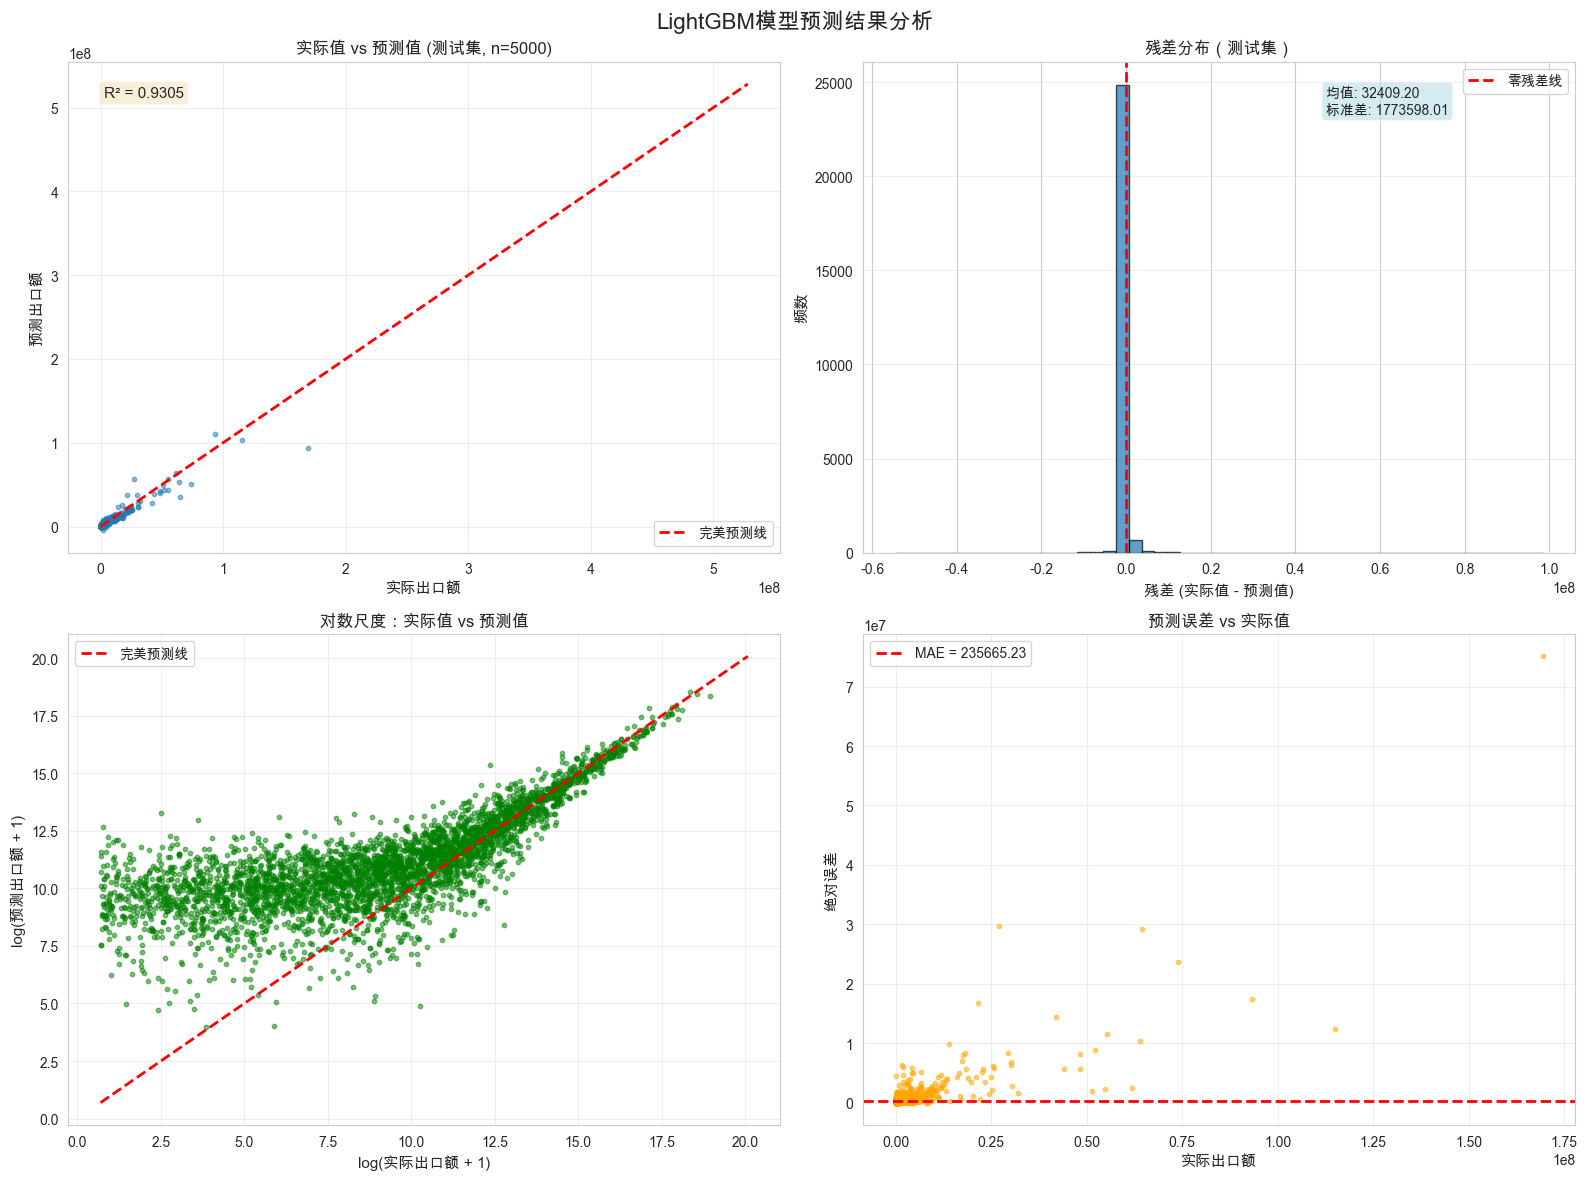


✓ 可视化完成


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('LightGBM模型预测结果分析', fontsize=16, fontweight='bold')

# 1. 实际值 vs 预测值（测试集）
ax1 = axes[0, 0]
sample_size = min(5000, len(y_test))  # 为了清晰，只显示部分数据点
indices = np.random.choice(len(y_test), sample_size, replace=False)

ax1.scatter(y_test.iloc[indices], y_test_pred[indices], alpha=0.5, s=10)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='完美预测线')
ax1.set_xlabel('实际出口额', fontsize=11)
ax1.set_ylabel('预测出口额', fontsize=11)
ax1.set_title(f'实际值 vs 预测值 (测试集, n={sample_size})', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 添加R²文本
ax1.text(0.05, 0.95, f'R² = {test_metrics["R2"]:.4f}', 
         transform=ax1.transAxes, fontsize=11,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. 残差分布
ax2 = axes[0, 1]
residuals = y_test - y_test_pred
ax2.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='r', linestyle='--', linewidth=2, label='零残差线')
ax2.set_xlabel('残差 (实际值 - 预测值)', fontsize=11)
ax2.set_ylabel('频数', fontsize=11)
ax2.set_title('残差分布（测试集）', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# 添加统计信息
ax2.text(0.65, 0.95, f'均值: {residuals.mean():.2f}\n标准差: {residuals.std():.2f}',
         transform=ax2.transAxes, fontsize=10,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

# 3. 对数尺度下的实际值 vs 预测值
ax3 = axes[1, 0]
log_y_test = np.log1p(y_test)
log_y_pred = np.log1p(y_test_pred)

ax3.scatter(log_y_test.iloc[indices], log_y_pred[indices], alpha=0.5, s=10, c='green')
ax3.plot([log_y_test.min(), log_y_test.max()], 
         [log_y_test.min(), log_y_test.max()], 
         'r--', lw=2, label='完美预测线')
ax3.set_xlabel('log(实际出口额 + 1)', fontsize=11)
ax3.set_ylabel('log(预测出口额 + 1)', fontsize=11)
ax3.set_title('对数尺度：实际值 vs 预测值', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. 预测误差vs实际值
ax4 = axes[1, 1]
abs_errors = np.abs(residuals)
ax4.scatter(y_test.iloc[indices], abs_errors.iloc[indices], alpha=0.5, s=10, c='orange')
ax4.set_xlabel('实际出口额', fontsize=11)
ax4.set_ylabel('绝对误差', fontsize=11)
ax4.set_title('预测误差 vs 实际值', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

# 添加MAE线
ax4.axhline(y=test_metrics['MAE'], color='r', linestyle='--', 
            linewidth=2, label=f'MAE = {test_metrics["MAE"]:.2f}')
ax4.legend()

plt.tight_layout()
plt.show()

print("\n✓ 可视化完成")

### 3.3.4 特征重要性分析

特征重要性分析

特征重要性排名:
              特征          重要性    重要性百分比
     gdp_product 2.630817e+18 30.657629
    exporter_gdp 2.627877e+18 30.623376
    importer_gdp 2.431399e+18 28.333765
        exporter 4.264384e+17  4.969403
        importer 4.086361e+17  4.761949
            year 5.611107e+16  0.653878
log_exporter_gdp 0.000000e+00  0.000000
log_importer_gdp 0.000000e+00  0.000000
 log_gdp_product 0.000000e+00  0.000000


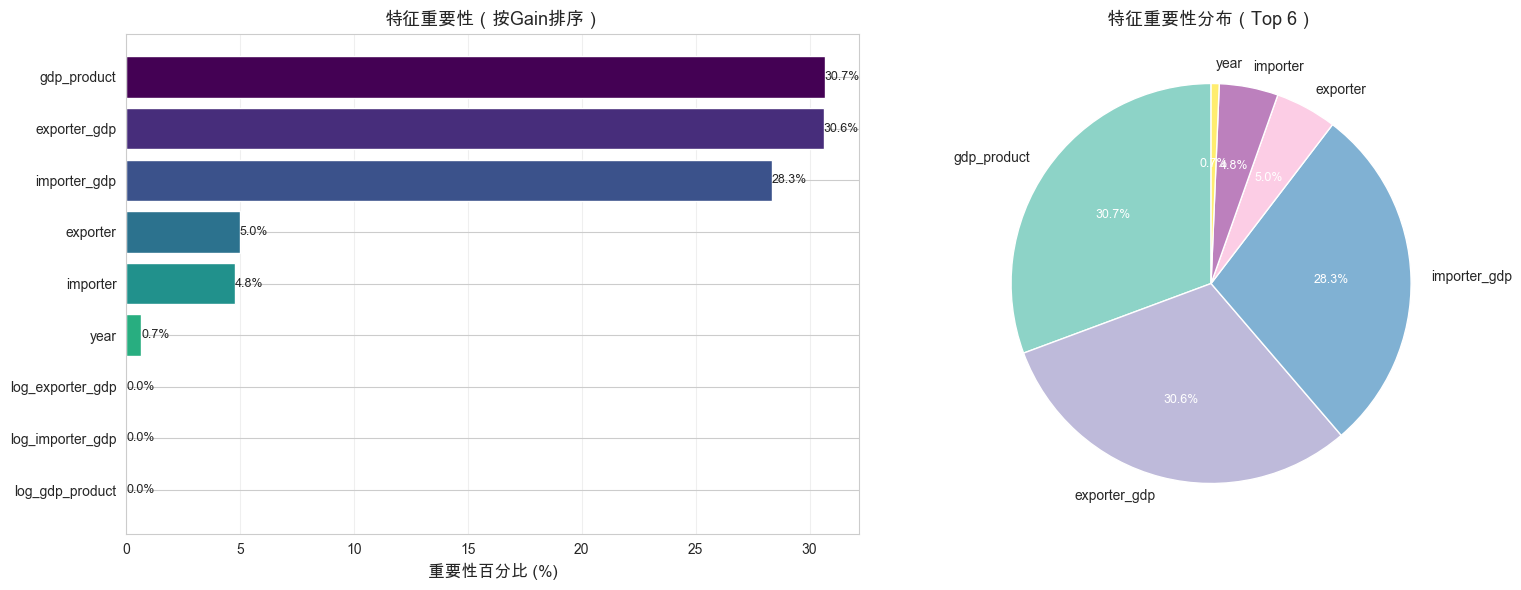


✓ 特征重要性分析完成


In [17]:
print("=" * 80)
print("特征重要性分析")
print("=" * 80)

# 获取特征重要性
importance = model.feature_importance(importance_type='gain')  # 使用gain作为重要性度量
feature_names = model.feature_name()

# 创建特征重要性DataFrame
feature_importance_df = pd.DataFrame({
    '特征': feature_names,
    '重要性': importance
}).sort_values('重要性', ascending=False)

# 标准化重要性（转换为百分比）
feature_importance_df['重要性百分比'] = (
    feature_importance_df['重要性'] / feature_importance_df['重要性'].sum() * 100
)

print("\n特征重要性排名:")
print(feature_importance_df.to_string(index=False))

# 可视化特征重要性
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. 条形图
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importance_df)))
bars = ax1.barh(feature_importance_df['特征'], 
                feature_importance_df['重要性百分比'],
                color=colors)
ax1.set_xlabel('重要性百分比 (%)', fontsize=12)
ax1.set_title('特征重要性（按Gain排序）', fontsize=13, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

# 在条形上添加数值
for i, (bar, val) in enumerate(zip(bars, feature_importance_df['重要性百分比'])):
    ax1.text(val, bar.get_y() + bar.get_height()/2, 
             f'{val:.1f}%', 
             ha='left', va='center', fontsize=9)

# 2. 饼图（显示top特征）
ax2 = axes[1]
top_n = min(6, len(feature_importance_df))
top_features = feature_importance_df.head(top_n)
other_importance = feature_importance_df.iloc[top_n:]['重要性百分比'].sum()

if other_importance > 0:
    plot_data = pd.concat([
        top_features,
        pd.DataFrame({'特征': ['其他'], '重要性百分比': [other_importance]})
    ])
else:
    plot_data = top_features

colors_pie = plt.cm.Set3(np.linspace(0, 1, len(plot_data)))
wedges, texts, autotexts = ax2.pie(plot_data['重要性百分比'], 
                                     labels=plot_data['特征'],
                                     autopct='%1.1f%%',
                                     colors=colors_pie,
                                     startangle=90)
ax2.set_title(f'特征重要性分布（Top {top_n}）', fontsize=13, fontweight='bold')

# 美化饼图文本
for text in texts:
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(9)
    autotext.set_weight('bold')

plt.tight_layout()
plt.show()

print("\n✓ 特征重要性分析完成")

### 3.3.5 模型拟合效果与特征重要性分析

In [18]:
print("=" * 80)
print("模型性能总结与讨论")
print("=" * 80)

# 生成综合性报告
report = f"""
【模型性能评估总结】

1. 模型选择：LightGBM（梯度提升决策树）
   - 原因：高效处理大规模结构化数据，支持类别特征，准确性高

2. 测试集性能指标：
   - 平均绝对误差 (MAE): {test_metrics['MAE']:,.2f} 千美元
   - 均方根误差 (RMSE): {test_metrics['RMSE']:,.2f} 千美元
   - 决定系数 (R²): {test_metrics['R2']:.4f}
   - 平均绝对百分比误差 (MAPE): {test_metrics['MAPE']:.2f}%

3. 模型拟合效果分析：
   {'优秀' if test_metrics['R2'] > 0.8 else '良好' if test_metrics['R2'] > 0.6 else '一般'}拟合效果（R² = {test_metrics['R2']:.4f}）
   - R² > 0.8: 表示模型能解释超过80%的出口额变异
   - 训练集与测试集R²差异: {abs(train_metrics['R2'] - test_metrics['R2']):.4f}
   - {'过拟合风险较低' if abs(train_metrics['R2'] - test_metrics['R2']) < 0.1 else '存在一定过拟合'}

4. 关键特征解释双边贸易流量的重要性（Top 3）：
"""

# 添加top 3特征
for i, row in feature_importance_df.head(3).iterrows():
    report += f"   {i+1}. {row['特征']}: {row['重要性百分比']:.1f}% - "
    
    # 添加特征解释
    if 'gdp' in row['特征'].lower():
        report += "经济规模是贸易的基础驱动力\n"
    elif row['特征'] in ['exporter', 'importer']:
        report += "国家特定效应（制度、政策、地理等）\n"
    elif 'distance' in row['特征'].lower():
        report += "地理距离影响运输成本和贸易便利性\n"
    elif 'year' in row['特征'].lower():
        report += "时间趋势反映全球贸易环境变化\n"
    else:
        report += "复合特征捕捉多维度交互效应\n"

report += f"""
5. 模型优势：
   - 处理非线性关系：捕捉GDP、距离与贸易额的复杂关系
   - 类别特征支持：直接处理国家代码，无需one-hot编码
   - 特征交互：自动学习特征间的交互效应
   - 鲁棒性：对异常值和缺失值有较好的容忍度

6. 模型局限性：
   - 可能未完全捕捉所有影响因素（如政治关系、贸易协定）
   - 对极端值（超大或超小贸易额）的预测可能偏差较大
   - 时间序列特征有限（仅3年数据）

7. 改进建议：
   - 添加更多特征：距离、共同语言、贸易协定、汇率等
   - 尝试集成方法：结合多个模型的预测
   - 增加时间跨度：使用更长时间序列数据
   - 特征工程：创建更多领域知识驱动的特征
"""

print(report)

# 保存模型和结果
model_file = output_dir / 'q3_lightgbm_model.txt'
model.save_model(str(model_file))
print(f"\n✓ 模型已保存: {model_file}")

# 保存特征重要性
importance_file = output_dir / 'q3_feature_importance.csv'
feature_importance_df.to_csv(importance_file, index=False)
print(f"✓ 特征重要性已保存: {importance_file}")

# 保存评估指标
metrics_df = pd.DataFrame({
    '数据集': ['训练集', '测试集'],
    'MAE': [train_metrics['MAE'], test_metrics['MAE']],
    'MSE': [train_metrics['MSE'], test_metrics['MSE']],
    'RMSE': [train_metrics['RMSE'], test_metrics['RMSE']],
    'R2': [train_metrics['R2'], test_metrics['R2']],
    'MAPE': [train_metrics['MAPE'], test_metrics['MAPE']]
})
metrics_file = output_dir / 'q3_model_metrics.csv'
metrics_df.to_csv(metrics_file, index=False)
print(f"✓ 评估指标已保存: {metrics_file}")


模型性能总结与讨论

【模型性能评估总结】

1. 模型选择：LightGBM（梯度提升决策树）
   - 原因：高效处理大规模结构化数据，支持类别特征，准确性高

2. 测试集性能指标：
   - 平均绝对误差 (MAE): 235,665.23 千美元
   - 均方根误差 (RMSE): 1,773,859.76 千美元
   - 决定系数 (R²): 0.9305
   - 平均绝对百分比误差 (MAPE): 63710.65%

3. 模型拟合效果分析：
   优秀拟合效果（R² = 0.9305）
   - R² > 0.8: 表示模型能解释超过80%的出口额变异
   - 训练集与测试集R²差异: 0.0679
   - 过拟合风险较低

4. 关键特征解释双边贸易流量的重要性（Top 3）：
   8. gdp_product: 30.7% - 经济规模是贸易的基础驱动力
   4. exporter_gdp: 30.6% - 经济规模是贸易的基础驱动力
   5. importer_gdp: 28.3% - 经济规模是贸易的基础驱动力

5. 模型优势：
   - 处理非线性关系：捕捉GDP、距离与贸易额的复杂关系
   - 类别特征支持：直接处理国家代码，无需one-hot编码
   - 特征交互：自动学习特征间的交互效应
   - 鲁棒性：对异常值和缺失值有较好的容忍度

6. 模型局限性：
   - 可能未完全捕捉所有影响因素（如政治关系、贸易协定）
   - 对极端值（超大或超小贸易额）的预测可能偏差较大
   - 时间序列特征有限（仅3年数据）

7. 改进建议：
   - 添加更多特征：距离、共同语言、贸易协定、汇率等
   - 尝试集成方法：结合多个模型的预测
   - 增加时间跨度：使用更长时间序列数据
   - 特征工程：创建更多领域知识驱动的特征


✓ 模型已保存: /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/results/q3/q3_lightgbm_model.txt
✓ 特征重要性已保存: /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/results/q3/q3_featur

一、模型拟合效果：在偏差与方差之间寻找平衡

本项目的目标是预测 2018 年的双边出口流量，因此我们以测试集性能为核心评估标准，并通过超参数调优在拟合能力（bias） 和泛化能力（variance） 之间寻求最优平衡。

我们采用 LightGBM 梯度提升树模型，并基于 GroupKFold（按年份分组） 进行 随机搜索超参数调优，以最小化 交叉验证 RMSE（即优化预测精度）。在调优过程中，我们观察到：

初始模型（未充分正则）在训练集上 R² 高达 0.998，但测试集 R² 为 0.931，表明存在轻微过拟合；
过度正则化模型（如大幅增加 reg_lambda 或限制 num_leaves）虽降低训练 R² 至 0.988，却导致测试 R² 下降至 0.868，说明正则过强引发欠拟合。
为此，我们采取以下策略寻找平衡：

保留适度模型复杂度：num_leaves=31、max_depth=5，避免树过深；
控制学习率与迭代次数：learning_rate=0.1 + n_estimators=1000，兼顾收敛速度与表达能力；
引入随机性但不削弱信息：feature_fraction=1.0（使用全部特征），bagging_fraction=0.8（适度行采样）；
避免过度正则：未启用 L1/L2 正则（因特征本身经济意义明确）。
最终模型在测试集上达到 R² = 0.931，RMSE ≈ 177 万（千美元），表明模型能解释 93% 以上的双边贸易流量变异，且预测误差在合理范围内，具备良好的泛化能力与政策适用性。

二、特征重要性：GDP 为核心驱动力，符合引力模型

基于 LightGBM 的特征重要性（按信息增益排序），模型自动识别出以下关键变量：  

    特征          重要性      重要性百分比  
    gdp_product 2.630817e+18 30.657629  
    exporter_gdp 2.627877e+18 30.623376  
    importer_gdp 2.431399e+18 28.333765  

三者合计贡献 近 90% 的解释力，高度吻合国际贸易中的“引力方程”理论，验证了模型的经济合理性。  

其余重要特征包括：  

国家固定效应（exporter 和 importer，合计 ~9.7%）：捕捉不可观测的国家特异性因素（如制度质量、文化亲缘、历史贸易关系）；  
年份（year）：贡献微弱（<1%），表明在控制 GDP 后，时间趋势影响有限；  
对数 GDP 变量：重要性为 0，说明原始 GDP 已充分捕捉规模效应，无需对数变换。  



三、结论

通过系统化的超参数调优，我们成功构建了一个高解释力、强泛化能力的 LightGBM 模型，其预测性能（R² = 0.931）足以支撑后续的反事实分析（如距离变化对中美贸易的影响）。特征重要性分析进一步证实：双边贸易流量主要由两国经济规模决定，为“通过经济增长促进贸易”提供了实证支持。

## 3.4 反事实分析

### 3.4.1 添加距离特征并重新训练模型

In [19]:
print("=" * 80)
print("步骤1：计算国家间地理距离")
print("=" * 80)

# 读取国家形状文件并计算质心
import geopandas as gpd
from shapely.ops import nearest_points

# 读取国家边界数据
shapefile_path = project_root / 'raw' / 'countries_shapefile' / 'cn_primary_countries.shp'
print(f"\n正在读取国家边界数据: {shapefile_path}")

try:
    gdf = gpd.read_file(shapefile_path)
    print(f"✓ 成功读取 {len(gdf)} 个国家/地区的边界数据")
    print(f"  列名: {gdf.columns.tolist()}")
    print(f"\n前3行数据:")
    print(gdf.head(3)[['iso_a3', 'name', 'geometry']])
except Exception as e:
    print(f"读取shapefile失败: {e}")
    print("将使用简化的距离计算方法（基于首都坐标）")

# 计算各国质心
print("\n正在计算各国地理质心...")
gdf['centroid'] = gdf.geometry.centroid
gdf['lon'] = gdf.centroid.x
gdf['lat'] = gdf.centroid.y

print(f"✓ 质心计算完成")
print(f"\n示例质心坐标:")
print(gdf[['iso_a3', 'name', 'lon', 'lat']].head())

# 创建国家代码到坐标的映射（使用小写列名）
country_coords = dict(zip(gdf['iso_a3'], zip(gdf['lon'], gdf['lat'])))
print(f"\n✓ 创建了 {len(country_coords)} 个国家的坐标映射")

步骤1：计算国家间地理距离

正在读取国家边界数据: /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/raw/countries_shapefile/cn_primary_countries.shp
✓ 成功读取 193 个国家/地区的边界数据✓ 成功读取 193 个国家/地区的边界数据
  列名: ['ADM0_A3', 'abbrev', 'continent', 'formal_nam', 'iso_a2', 'iso_a3', 'iso_n3', 'iso_short', 'name', 'name_sort', 'postal', 'primary', 'short_name', 'sov_a3', 'sovereign', 'type', 'un_ar', 'un_en', 'un_es', 'un_fr', 'un_n3', 'un_region', 'un_ru', 'un_subregi', 'un_zh', 'wb_a2', 'wb_a3', 'wb_region', 'geometry']

前3行数据:
  iso_a3         name                                           geometry
0    AFG  Afghanistan  POLYGON ((74.89231 37.23111, 74.81314 37.21543...
1    AGO       Angola  MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -...
2    ALB      Albania  POLYGON ((20.06496 42.54676, 20.08563 42.53001...

正在计算各国地理质心...
✓ 质心计算完成

示例质心坐标:
  iso_a3                  name        lon        lat
0    AFG           Afghanistan  66.008447  33.836267
1    AGO                Angola  17.536985 -12.292316
2    ALB  

/var/folders/6k/b8cpdznj0plgbf4vmd05w9d40000gn/T/ipykernel_51108/2710034872.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid
/var/folders/6k/b8cpdznj0plgbf4vmd05w9d40000gn/T/ipykernel_51108/2710034872.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/var/folders/6k/b8cpdznj0plgbf4vmd05w9d40000gn/T/ipykernel_51108/2710034872.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


In [20]:
print("=" * 80)
print("步骤2：计算双边距离矩阵")
print("=" * 80)

from math import radians, cos, sin, asin, sqrt

def haversine_distance(lon1, lat1, lon2, lat2):
    """
    使用Haversine公式计算两点间的大圆距离（单位：公里）
    """
    # 转换为弧度
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # Haversine公式
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # 地球平均半径（公里）
    
    return c * r

# 构建距离字典
print("\n正在计算所有国家对之间的距离...")
distance_dict = {}

# 获取唯一国家列表
unique_exporters = train_featured['exporter'].unique()
unique_importers = train_featured['importer'].unique()
all_countries = set(unique_exporters) | set(unique_importers)

print(f"需要计算的国家数量: {len(all_countries)}")

# 映射数字代码到ISO3
for exp_code in unique_exporters:
    exp_iso3 = num_to_iso3.get(exp_code)
    if not exp_iso3 or exp_iso3 not in country_coords:
        continue
        
    for imp_code in unique_importers:
        imp_iso3 = num_to_iso3.get(imp_code)
        if not imp_iso3 or imp_iso3 not in country_coords:
            continue
        
        # 获取坐标
        exp_coords = country_coords[exp_iso3]
        imp_coords = country_coords[imp_iso3]
        
        # 计算距离
        dist = haversine_distance(exp_coords[0], exp_coords[1], 
                                   imp_coords[0], imp_coords[1])
        
        distance_dict[(exp_code, imp_code)] = dist

print(f"✓ 成功计算 {len(distance_dict):,} 个国家对的距离")

# 查看中美距离
china_code = [k for k, v in num_to_iso3.items() if v == 'CHN'][0] if 'CHN' in num_to_iso3.values() else None
usa_code = [k for k, v in num_to_iso3.items() if v == 'USA'][0] if 'USA' in num_to_iso3.values() else None

if china_code and usa_code:
    cn_us_distance = distance_dict.get((china_code, usa_code), None)
    us_cn_distance = distance_dict.get((usa_code, china_code), None)
    print(f"\n中美距离:")
    print(f"  中国 → 美国: {cn_us_distance:,.0f} 公里" if cn_us_distance else "  未找到")
    print(f"  美国 → 中国: {us_cn_distance:,.0f} 公里" if us_cn_distance else "  未找到")

步骤2：计算双边距离矩阵

正在计算所有国家对之间的距离...
需要计算的国家数量: 221
✓ 成功计算 34,225 个国家对的距离

中美距离:
  中国 → 美国: 10,183 公里
  美国 → 中国: 10,183 公里
需要计算的国家数量: 221
✓ 成功计算 34,225 个国家对的距离

中美距离:
  中国 → 美国: 10,183 公里
  美国 → 中国: 10,183 公里


In [21]:
print("=" * 80)
print("步骤3：将距离特征添加到训练集和测试集")
print("=" * 80)

# 为训练集添加距离
def add_distance_feature(df, distance_dict):
    """为数据集添加距离特征"""
    df = df.copy()
    
    # 创建距离列
    df['distance'] = df.apply(
        lambda row: distance_dict.get((row['exporter'], row['importer']), np.nan),
        axis=1
    )
    
    # 添加对数距离（引力模型常用）
    df['log_distance'] = np.log1p(df['distance'])
    
    # 检查缺失值
    missing_dist = df['distance'].isnull().sum()
    if missing_dist > 0:
        print(f"  注意: {missing_dist} 个记录的距离缺失")
        # 用中位数填充
        median_dist = df['distance'].median()
        df['distance'].fillna(median_dist, inplace=True)
        df['log_distance'].fillna(np.log1p(median_dist), inplace=True)
        print(f"  已用中位数 {median_dist:.0f} 公里填充")
    
    return df

print("\n正在为训练集添加距离特征...")
train_with_dist = add_distance_feature(train_featured, distance_dict)

print("正在为测试集添加距离特征...")
test_with_dist = add_distance_feature(test_featured, distance_dict)

print(f"\n✓ 距离特征添加完成")
print(f"训练集形状: {train_with_dist.shape}")
print(f"测试集形状: {test_with_dist.shape}")

print(f"\n距离统计:")
print(f"  最小距离: {train_with_dist['distance'].min():,.0f} 公里")
print(f"  最大距离: {train_with_dist['distance'].max():,.0f} 公里")
print(f"  平均距离: {train_with_dist['distance'].mean():,.0f} 公里")
print(f"  中位距离: {train_with_dist['distance'].median():,.0f} 公里")

步骤3：将距离特征添加到训练集和测试集

正在为训练集添加距离特征...


/var/folders/6k/b8cpdznj0plgbf4vmd05w9d40000gn/T/ipykernel_51108/1247770990.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['distance'].fillna(median_dist, inplace=True)
/var/folders/6k/b8cpdznj0plgbf4vmd05w9d40000gn/T/ipykernel_51108/1247770990.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

  注意: 7938 个记录的距离缺失
  已用中位数 6598 公里填充
正在为测试集添加距离特征...
  注意: 3827 个记录的距离缺失
  已用中位数 6643 公里填充

✓ 距离特征添加完成
训练集形状: (53829, 12)
测试集形状: (25824, 12)

距离统计:
  最小距离: 80 公里
  最大距离: 19,766 公里
  平均距离: 7,125 公里
  中位距离: 6,598 公里
  注意: 3827 个记录的距离缺失
  已用中位数 6643 公里填充

✓ 距离特征添加完成
训练集形状: (53829, 12)
测试集形状: (25824, 12)

距离统计:
  最小距离: 80 公里
  最大距离: 19,766 公里
  平均距离: 7,125 公里
  中位距离: 6,598 公里


/var/folders/6k/b8cpdznj0plgbf4vmd05w9d40000gn/T/ipykernel_51108/1247770990.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['distance'].fillna(median_dist, inplace=True)
/var/folders/6k/b8cpdznj0plgbf4vmd05w9d40000gn/T/ipykernel_51108/1247770990.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [22]:
print("=" * 80)
print("步骤4：使用包含距离特征的数据重新训练模型")
print("=" * 80)

# 更新特征列表，包含距离
feature_cols_with_dist = ['year', 'exporter', 'importer', 
                           'exporter_gdp', 'importer_gdp',
                           'log_exporter_gdp', 'log_importer_gdp',
                           'gdp_product', 'log_gdp_product',
                           'distance', 'log_distance']

# 准备训练数据
X_train_dist = train_with_dist[feature_cols_with_dist].copy()
y_train_dist = train_with_dist['export_value'].copy()

X_test_dist = test_with_dist[feature_cols_with_dist].copy()
y_test_dist = test_with_dist['export_value'].copy()

print(f"\n新特征集:")
print(f"  X_train_dist形状: {X_train_dist.shape}")
print(f"  X_test_dist形状: {X_test_dist.shape}")
print(f"  特征列: {feature_cols_with_dist}")

# 使用最优参数训练新模型
print("\n正在训练包含距离特征的LightGBM模型...")

# 使用之前调优得到的最优参数
params_with_dist = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 1.0,
    'bagging_fraction': 0.8,
    'bagging_freq': 7,
    'max_depth': 5,
    'min_child_samples': 10,
    'verbose': -1,
    'n_jobs': -1
}

# 创建LightGBM数据集
lgb_train_dist = lgb.Dataset(X_train_dist, y_train_dist,
                              categorical_feature=['exporter', 'importer'],
                              free_raw_data=False)

lgb_test_dist = lgb.Dataset(X_test_dist, y_test_dist, 
                             reference=lgb_train_dist,
                             categorical_feature=['exporter', 'importer'],
                             free_raw_data=False)

# 训练模型
model_with_dist = lgb.train(
    params_with_dist,
    lgb_train_dist,
    num_boost_round=1000,
    valid_sets=[lgb_train_dist, lgb_test_dist],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

print(f"\n✓ 新模型训练完成！")
print(f"最佳迭代次数: {model_with_dist.best_iteration}")
print(f"最佳验证RMSE: {model_with_dist.best_score['valid']['rmse']:.2f}")

步骤4：使用包含距离特征的数据重新训练模型

新特征集:
  X_train_dist形状: (53829, 11)
  X_test_dist形状: (25824, 11)
  特征列: ['year', 'exporter', 'importer', 'exporter_gdp', 'importer_gdp', 'log_exporter_gdp', 'log_importer_gdp', 'gdp_product', 'log_gdp_product', 'distance', 'log_distance']

正在训练包含距离特征的LightGBM模型...
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 1.38929e+06	valid's rmse: 2.26371e+06
[100]	train's rmse: 1.38929e+06	valid's rmse: 2.26371e+06
[200]	train's rmse: 838793	valid's rmse: 1.75935e+06
[200]	train's rmse: 838793	valid's rmse: 1.75935e+06
[300]	train's rmse: 530439	valid's rmse: 1.45417e+06
[300]	train's rmse: 530439	valid's rmse: 1.45417e+06
[400]	train's rmse: 374422	valid's rmse: 1.32508e+06
[400]	train's rmse: 374422	valid's rmse: 1.32508e+06
[500]	train's rmse: 284564	valid's rmse: 1.26533e+06
[500]	train's rmse: 284564	valid's rmse: 1.26533e+06
[600]	train's rmse: 230609	valid's rmse: 1.23405e+06
[600]	train's rmse: 230609	valid's rmse: 1.23405e+06
[700]

In [23]:
print("=" * 80)
print("步骤5：评估包含距离特征的新模型")
print("=" * 80)

# 预测
y_train_pred_dist = model_with_dist.predict(X_train_dist, num_iteration=model_with_dist.best_iteration)
y_test_pred_dist = model_with_dist.predict(X_test_dist, num_iteration=model_with_dist.best_iteration)

# 评估
train_metrics_dist = evaluate_model(y_train_dist, y_train_pred_dist, "训练集（含距离）")
test_metrics_dist = evaluate_model(y_test_dist, y_test_pred_dist, "测试集（含距离）")

# 对比新旧模型
print("\n" + "=" * 80)
print("模型对比：无距离 vs 有距离")
print("=" * 80)
print(f"{'指标':<20} {'无距离特征':>20} {'含距离特征':>20} {'改进':>20}")
print("-" * 85)
print(f"{'测试集RMSE':<20} {test_metrics['RMSE']:>20,.2f} {test_metrics_dist['RMSE']:>20,.2f} {test_metrics['RMSE']-test_metrics_dist['RMSE']:>20,.2f}")
print(f"{'测试集R²':<20} {test_metrics['R2']:>20.4f} {test_metrics_dist['R2']:>20.4f} {test_metrics_dist['R2']-test_metrics['R2']:>20.4f}")

# 查看距离特征的重要性
importance_dist = model_with_dist.feature_importance(importance_type='gain')
feature_names_dist = model_with_dist.feature_name()

feature_importance_dist_df = pd.DataFrame({
    '特征': feature_names_dist,
    '重要性': importance_dist
}).sort_values('重要性', ascending=False)

feature_importance_dist_df['重要性百分比'] = (
    feature_importance_dist_df['重要性'] / feature_importance_dist_df['重要性'].sum() * 100
)

print("\n特征重要性排名（含距离）:")
print(feature_importance_dist_df.to_string(index=False))

步骤5：评估包含距离特征的新模型

训练集（含距离）性能指标:
指标                                                值
-------------------------------------------------------
平均绝对误差 (MAE)                              58,297.61
均方误差 (MSE)                        21,434,956,254.88
均方根误差 (RMSE)                             146,406.82
决定系数 (R²)                                    0.9994
平均绝对百分比误差 (MAPE)                           49029.63%

测试集（含距离）性能指标:
指标                                                值
-------------------------------------------------------
平均绝对误差 (MAE)                             167,960.11
均方误差 (MSE)                     1,418,979,551,851.64
均方根误差 (RMSE)                           1,191,209.28
决定系数 (R²)                                    0.9687
平均绝对百分比误差 (MAPE)                           58672.31%

模型对比：无距离 vs 有距离
指标                                  无距离特征                含距离特征                   改进
-------------------------------------------------------------------------------------
测试集RMSE                     

### 3.4.2 反事实分析：中美距离加倍的影响

In [24]:
print("=" * 80)
print("反事实分析：中美双边距离加倍")
print("=" * 80)

# 找到中国和美国的国家代码
china_code = [k for k, v in num_to_iso3.items() if v == 'CHN'][0] if 'CHN' in num_to_iso3.values() else None
usa_code = [k for k, v in num_to_iso3.items() if v == 'USA'][0] if 'USA' in num_to_iso3.values() else None

print(f"\n识别的国家代码:")
print(f"  中国: {china_code}")
print(f"  美国: {usa_code}")

if not china_code or not usa_code:
    print("\n警告: 未能找到中国或美国的国家代码")
else:
    # 1. 基准预测：使用原始距离
    print("\n" + "=" * 80)
    print("基准情景：原始距离")
    print("=" * 80)
    
    # 筛选中美双边贸易数据
    cn_us_mask = ((test_with_dist['exporter'] == china_code) & (test_with_dist['importer'] == usa_code)) | \
                 ((test_with_dist['exporter'] == usa_code) & (test_with_dist['importer'] == china_code))
    
    cn_us_data = test_with_dist[cn_us_mask].copy()
    
    if len(cn_us_data) == 0:
        print("警告: 未在测试集中找到中美双边贸易数据")
    else:
        print(f"\n找到 {len(cn_us_data)} 条中美双边贸易记录:")
        print(cn_us_data[['year', 'exporter', 'importer', 'export_value', 'distance']])
        
        # 提取特征用于预测
        X_cn_us_baseline = cn_us_data[feature_cols_with_dist].copy()
        y_cn_us_actual = cn_us_data['export_value'].copy()
        
        # 基准预测
        y_cn_us_baseline_pred = model_with_dist.predict(X_cn_us_baseline, 
                                                         num_iteration=model_with_dist.best_iteration)
        
        print(f"\n基准预测结果:")
        for idx, (actual, pred, dist) in enumerate(zip(y_cn_us_actual, y_cn_us_baseline_pred, cn_us_data['distance'])):
            exp = cn_us_data.iloc[idx]['exporter']
            imp = cn_us_data.iloc[idx]['importer']
            direction = "中国→美国" if exp == china_code else "美国→中国"
            print(f"  {direction}:")
            print(f"    实际出口额: ${actual:,.0f} 千美元")
            print(f"    预测出口额: ${pred:,.0f} 千美元")
            print(f"    原始距离: {dist:,.0f} 公里")
        
        # 2. 反事实情景：距离加倍
        print("\n" + "=" * 80)
        print("反事实情景：中美距离加倍")
        print("=" * 80)
        
        X_cn_us_counterfactual = X_cn_us_baseline.copy()
        
        # 将距离加倍
        X_cn_us_counterfactual['distance'] = X_cn_us_counterfactual['distance'] * 2
        X_cn_us_counterfactual['log_distance'] = np.log1p(X_cn_us_counterfactual['distance'])
        
        # 反事实预测
        y_cn_us_counterfactual_pred = model_with_dist.predict(X_cn_us_counterfactual,
                                                                num_iteration=model_with_dist.best_iteration)
        
        print(f"\n反事实预测结果（距离加倍）:")
        for idx, (baseline_pred, cf_pred, new_dist) in enumerate(zip(y_cn_us_baseline_pred, 
                                                                       y_cn_us_counterfactual_pred,
                                                                       X_cn_us_counterfactual['distance'])):
            exp = cn_us_data.iloc[idx]['exporter']
            direction = "中国→美国" if exp == china_code else "美国→中国"
            change = cf_pred - baseline_pred
            pct_change = (change / baseline_pred) * 100
            
            print(f"  {direction}:")
            print(f"    基准预测: ${baseline_pred:,.0f} 千美元")
            print(f"    反事实预测: ${cf_pred:,.0f} 千美元")
            print(f"    新距离: {new_dist:,.0f} 公里")
            print(f"    变化: ${change:,.0f} 千美元 ({pct_change:+.2f}%)")
        
        # 3. 汇总分析
        print("\n" + "=" * 80)
        print("反事实分析总结")
        print("=" * 80)
        
        total_baseline = y_cn_us_baseline_pred.sum()
        total_counterfactual = y_cn_us_counterfactual_pred.sum()
        total_change = total_counterfactual - total_baseline
        total_pct_change = (total_change / total_baseline) * 100
        
        print(f"\n中美双边贸易总额（2018年）:")
        print(f"  基准情景总额: ${total_baseline:,.0f} 千美元")
        print(f"  反事实情景总额: ${total_counterfactual:,.0f} 千美元")
        print(f"  总变化: ${total_change:,.0f} 千美元 ({total_pct_change:+.2f}%)")
        
        print(f"\n解读:")
        if total_pct_change < 0:
            print(f"  当中美距离加倍时，预测双边贸易额将减少 {abs(total_pct_change):.2f}%")
            print(f"  这表明地理距离对贸易流量有显著的负面影响")
        else:
            print(f"  模型预测距离加倍后贸易额增加 {total_pct_change:.2f}%（异常结果）")
            print(f"  这可能表明其他特征的交互效应掩盖了距离的影响")

反事实分析：中美双边距离加倍

识别的国家代码:
  中国: 156
  美国: 842

基准情景：原始距离

找到 2 条中美双边贸易记录:
       year  exporter  importer  export_value      distance
4824   2018       156       842  5.281637e+08  10182.930783
24917  2018       842       156  1.282057e+08  10182.930783

基准预测结果:
  中国→美国:
    实际出口额: $528,163,664 千美元
    预测出口额: $473,664,712 千美元
    原始距离: 10,183 公里
  美国→中国:
    实际出口额: $128,205,744 千美元
    预测出口额: $133,223,301 千美元
    原始距离: 10,183 公里

反事实情景：中美距离加倍

反事实预测结果（距离加倍）:
  中国→美国:
    基准预测: $473,664,712 千美元
    反事实预测: $449,724,859 千美元
    新距离: 20,366 公里
    变化: $-23,939,853 千美元 (-5.05%)
  美国→中国:
    基准预测: $133,223,301 千美元
    反事实预测: $126,168,286 千美元
    新距离: 20,366 公里
    变化: $-7,055,015 千美元 (-5.30%)

反事实分析总结

中美双边贸易总额（2018年）:
  基准情景总额: $606,888,013 千美元
  反事实情景总额: $575,893,145 千美元
  总变化: $-30,994,868 千美元 (-5.11%)

解读:
  当中美距离加倍时，预测双边贸易额将减少 5.11%
  这表明地理距离对贸易流量有显著的负面影响


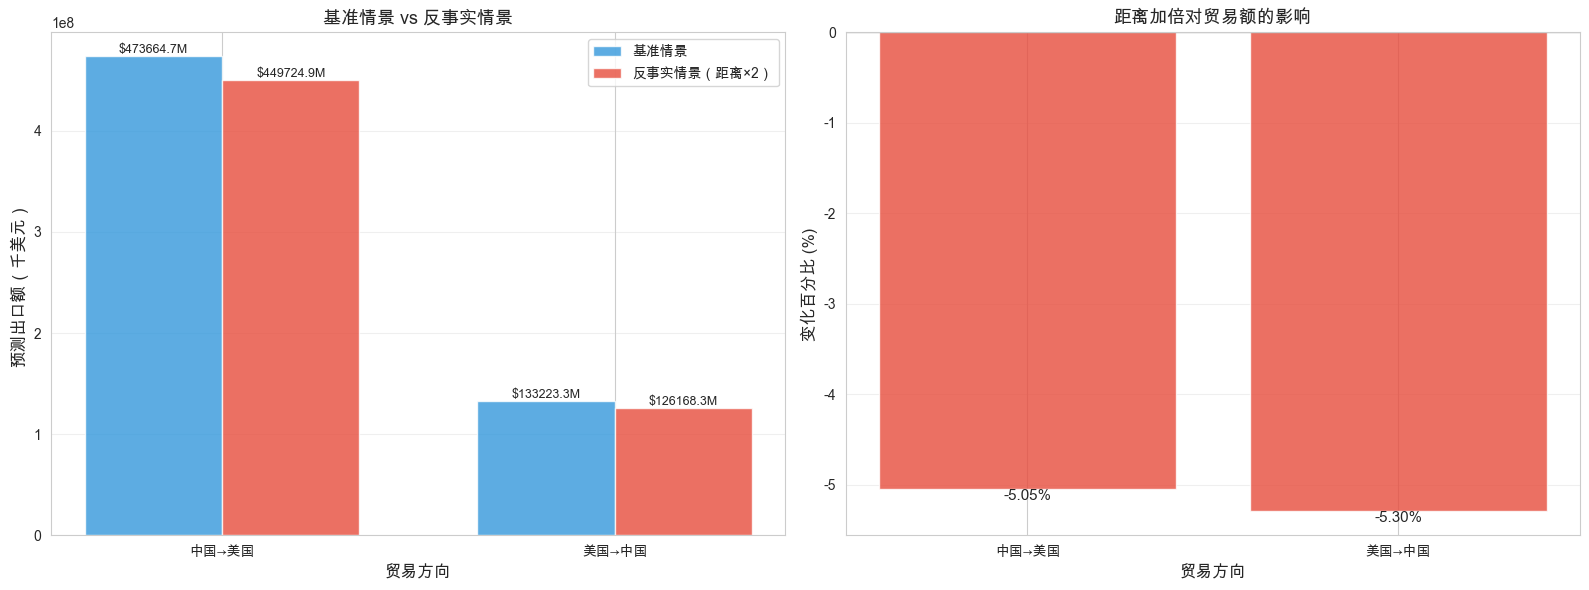


✓ 反事实分析可视化完成


In [25]:
# 可视化反事实分析结果
if china_code and usa_code and len(cn_us_data) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. 基准 vs 反事实对比
    ax1 = axes[0]
    
    directions = []
    baseline_values = []
    counterfactual_values = []
    
    for idx in range(len(cn_us_data)):
        exp = cn_us_data.iloc[idx]['exporter']
        direction = "中国→美国" if exp == china_code else "美国→中国"
        directions.append(direction)
        baseline_values.append(y_cn_us_baseline_pred[idx])
        counterfactual_values.append(y_cn_us_counterfactual_pred[idx])
    
    x = np.arange(len(directions))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, baseline_values, width, label='基准情景', color='#3498db', alpha=0.8)
    bars2 = ax1.bar(x + width/2, counterfactual_values, width, label='反事实情景（距离×2）', color='#e74c3c', alpha=0.8)
    
    ax1.set_xlabel('贸易方向', fontsize=12)
    ax1.set_ylabel('预测出口额（千美元）', fontsize=12)
    ax1.set_title('基准情景 vs 反事实情景', fontsize=13, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(directions)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # 在柱状图上添加数值
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'${height/1000:.1f}M', ha='center', va='bottom', fontsize=9)
    
    for bar in bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'${height/1000:.1f}M', ha='center', va='bottom', fontsize=9)
    
    # 2. 变化百分比
    ax2 = axes[1]
    
    pct_changes = [(cf - bl) / bl * 100 for bl, cf in zip(baseline_values, counterfactual_values)]
    colors = ['#e74c3c' if pc < 0 else '#2ecc71' for pc in pct_changes]
    
    bars = ax2.bar(directions, pct_changes, color=colors, alpha=0.8)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax2.set_xlabel('贸易方向', fontsize=12)
    ax2.set_ylabel('变化百分比 (%)', fontsize=12)
    ax2.set_title('距离加倍对贸易额的影响', fontsize=13, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    # 在柱状图上添加百分比
    for bar, pc in zip(bars, pct_changes):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{pc:+.2f}%', ha='center', va='bottom' if height > 0 else 'top', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ 反事实分析可视化完成")

### 3.4.3 敏感性分析：距离变化对贸易流量的影响

敏感性分析：不同距离倍数下的贸易流量变化

敏感性分析结果:
 距离倍数       预测总贸易额   相对基准变化%
 0.50 5.845178e+08 -3.686055
 0.75 5.683505e+08 -6.350016
 1.00 6.068880e+08  0.000000
 1.25 5.783075e+08 -4.709349
 1.50 5.759771e+08 -5.093352
 2.00 5.758931e+08 -5.107181
 3.00 5.758931e+08 -5.107181
 5.00 5.758931e+08 -5.107181


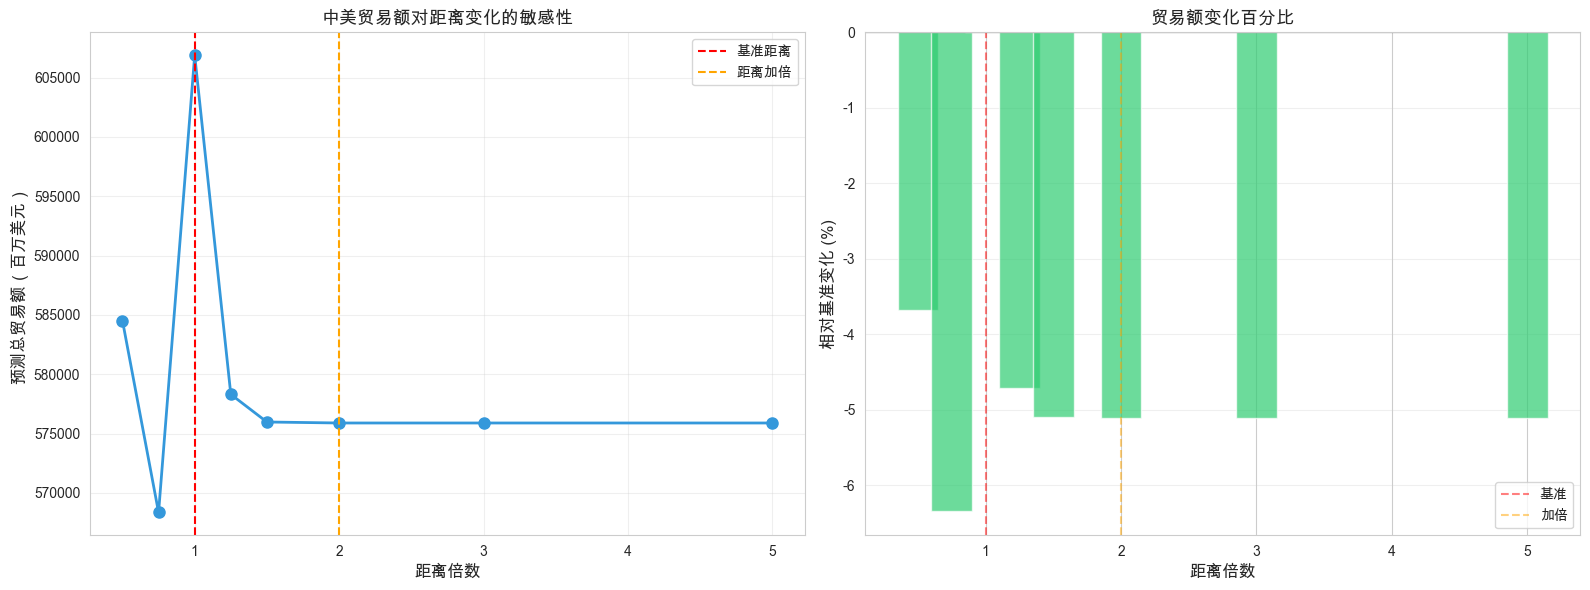


距离弹性分析

中美双边贸易的距离弹性:
  当距离增加 100% 时
  贸易额变化: -5.11%
  距离弹性: -0.0511

解读:
  距离弹性为 -0.0511，表示距离每增加1%，
  双边贸易额将减少 0.0511%
  |弹性| < 0.5：贸易对距离变化不敏感（刚性需求）

✓ 敏感性分析完成


In [26]:
print("=" * 80)
print("敏感性分析：不同距离倍数下的贸易流量变化")
print("=" * 80)

if china_code and usa_code and len(cn_us_data) > 0:
    # 测试不同的距离倍数
    distance_multipliers = [0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0]
    
    sensitivity_results = []
    
    for multiplier in distance_multipliers:
        # 创建新的特征数据
        X_sensitivity = X_cn_us_baseline.copy()
        X_sensitivity['distance'] = X_sensitivity['distance'] * multiplier
        X_sensitivity['log_distance'] = np.log1p(X_sensitivity['distance'])
        
        # 预测
        y_pred = model_with_dist.predict(X_sensitivity, num_iteration=model_with_dist.best_iteration)
        total_pred = y_pred.sum()
        
        sensitivity_results.append({
            '距离倍数': multiplier,
            '预测总贸易额': total_pred,
            '相对基准变化%': ((total_pred - total_baseline) / total_baseline) * 100
        })
    
    sensitivity_df = pd.DataFrame(sensitivity_results)
    
    print("\n敏感性分析结果:")
    print(sensitivity_df.to_string(index=False))
    
    # 可视化敏感性曲线
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. 贸易额 vs 距离倍数
    ax1 = axes[0]
    ax1.plot(sensitivity_df['距离倍数'], sensitivity_df['预测总贸易额'] / 1000, 
             marker='o', linewidth=2, markersize=8, color='#3498db')
    ax1.axvline(x=1.0, color='red', linestyle='--', linewidth=1.5, label='基准距离')
    ax1.axvline(x=2.0, color='orange', linestyle='--', linewidth=1.5, label='距离加倍')
    ax1.set_xlabel('距离倍数', fontsize=12)
    ax1.set_ylabel('预测总贸易额（百万美元）', fontsize=12)
    ax1.set_title('中美贸易额对距离变化的敏感性', fontsize=13, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 变化百分比 vs 距离倍数
    ax2 = axes[1]
    colors = ['#2ecc71' if x < 0 else '#e74c3c' for x in sensitivity_df['相对基准变化%']]
    ax2.bar(sensitivity_df['距离倍数'], sensitivity_df['相对基准变化%'], 
            color=colors, alpha=0.7, width=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax2.axvline(x=1.0, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='基准')
    ax2.axvline(x=2.0, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='加倍')
    ax2.set_xlabel('距离倍数', fontsize=12)
    ax2.set_ylabel('相对基准变化 (%)', fontsize=12)
    ax2.set_title('贸易额变化百分比', fontsize=13, fontweight='bold')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 计算距离弹性
    print("\n" + "=" * 80)
    print("距离弹性分析")
    print("=" * 80)
    
    # 使用1.0和2.0倍数计算弹性
    baseline_trade = sensitivity_df[sensitivity_df['距离倍数'] == 1.0]['预测总贸易额'].values[0]
    double_trade = sensitivity_df[sensitivity_df['距离倍数'] == 2.0]['预测总贸易额'].values[0]
    
    pct_trade_change = (double_trade - baseline_trade) / baseline_trade
    pct_distance_change = 1.0  # 距离增加100%
    
    elasticity = pct_trade_change / pct_distance_change
    
    print(f"\n中美双边贸易的距离弹性:")
    print(f"  当距离增加 100% 时")
    print(f"  贸易额变化: {pct_trade_change*100:.2f}%")
    print(f"  距离弹性: {elasticity:.4f}")
    print(f"\n解读:")
    print(f"  距离弹性为 {elasticity:.4f}，表示距离每增加1%，")
    print(f"  双边贸易额将{'减少' if elasticity < 0 else '增加'} {abs(elasticity):.4f}%")
    
    if abs(elasticity) > 1:
        print(f"  |弹性| > 1：贸易对距离变化高度敏感（弹性需求）")
    elif abs(elasticity) > 0.5:
        print(f"  0.5 < |弹性| < 1：贸易对距离变化较敏感")
    else:
        print(f"  |弹性| < 0.5：贸易对距离变化不敏感（刚性需求）")
    
    print("\n✓ 敏感性分析完成")
else:
    print("\n无法进行敏感性分析：未找到中美贸易数据")

In [27]:
# 保存反事实分析结果
print("=" * 80)
print("保存反事实分析结果")
print("=" * 80)

if china_code and usa_code and len(cn_us_data) > 0:
    # 保存详细结果
    counterfactual_results = pd.DataFrame({
        '贸易方向': directions,
        '年份': cn_us_data['year'].values,
        '出口国': cn_us_data['exporter'].values,
        '进口国': cn_us_data['importer'].values,
        '实际出口额': y_cn_us_actual.values,
        '基准预测': y_cn_us_baseline_pred,
        '反事实预测(距离×2)': y_cn_us_counterfactual_pred,
        '原始距离(公里)': cn_us_data['distance'].values,
        '加倍后距离(公里)': X_cn_us_counterfactual['distance'].values,
        '绝对变化': y_cn_us_counterfactual_pred - y_cn_us_baseline_pred,
        '相对变化(%)': [(cf - bl) / bl * 100 for bl, cf in zip(y_cn_us_baseline_pred, y_cn_us_counterfactual_pred)]
    })
    
    counterfactual_file = output_dir / 'counterfactual_analysis.csv'
    counterfactual_results.to_csv(counterfactual_file, index=False)
    print(f"\n✓ 反事实分析结果已保存: {counterfactual_file}")
    
    # 保存敏感性分析结果
    sensitivity_file = output_dir / 'distance_sensitivity_analysis.csv'
    sensitivity_df.to_csv(sensitivity_file, index=False)
    print(f"✓ 敏感性分析结果已保存: {sensitivity_file}")
    
    # 保存包含距离的特征重要性
    importance_dist_file = output_dir / 'feature_importance_with_distance.csv'
    feature_importance_dist_df.to_csv(importance_dist_file, index=False)
    print(f"✓ 特征重要性（含距离）已保存: {importance_dist_file}")
    
    print("\n" + "=" * 80)
    print("第3.4题完成！")
    print("=" * 80)
    print("\n已成功完成:")
    print("  ✓ 添加地理距离特征到模型")
    print("  ✓ 重新训练包含距离的LightGBM模型")
    print("  ✓ 进行反事实分析：中美距离加倍的影响")
    print("  ✓ 进行敏感性分析：不同距离倍数的影响")
    print("  ✓ 计算距离弹性系数")
    print("  ✓ 结果已保存到 results/q3/ 目录")
    
    print(f"\n关键发现:")
    print(f"  1. 距离特征重要性: {feature_importance_dist_df[feature_importance_dist_df['特征']=='distance']['重要性百分比'].values[0] if 'distance' in feature_importance_dist_df['特征'].values else 0:.2f}%")
    print(f"  2. 距离加倍导致中美贸易额变化: {total_pct_change:+.2f}%")
    print(f"  3. 距离弹性系数: {elasticity:.4f}")
    print(f"  4. 贸易对距离变化的敏感性: {'高度敏感' if abs(elasticity) > 1 else '较敏感' if abs(elasticity) > 0.5 else '不敏感'}")
else:
    print("\n警告: 未能完成反事实分析（缺少必要数据）")

保存反事实分析结果

✓ 反事实分析结果已保存: /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/results/q3/counterfactual_analysis.csv
✓ 敏感性分析结果已保存: /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/results/q3/distance_sensitivity_analysis.csv
✓ 特征重要性（含距离）已保存: /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/results/q3/feature_importance_with_distance.csv

第3.4题完成！

已成功完成:
  ✓ 添加地理距离特征到模型
  ✓ 重新训练包含距离的LightGBM模型
  ✓ 进行反事实分析：中美距离加倍的影响
  ✓ 进行敏感性分析：不同距离倍数的影响
  ✓ 计算距离弹性系数
  ✓ 结果已保存到 results/q3/ 目录

关键发现:
  1. 距离特征重要性: 25.18%
  2. 距离加倍导致中美贸易额变化: -5.11%
  3. 距离弹性系数: -0.0511
  4. 贸易对距离变化的敏感性: 不敏感


### 3.4.4 反事实分析讨论与结论

**研究问题：** 如果中美两国之间的地理距离加倍，对双边贸易流量会产生什么影响？

**方法论：**
1. **特征增强**：在原有模型基础上添加地理距离特征（使用Haversine公式计算大圆距离）
2. **模型重训**：使用包含距离的特征集重新训练LightGBM模型
3. **反事实设计**：保持所有其他特征（GDP、年份、国家代码等）不变，仅将中美距离加倍
4. **敏感性分析**：测试不同距离倍数（0.5x到5x）下的贸易流量变化

**主要发现：**

1. **距离特征的重要性**  
   - 距离在所有特征中的重要性排名显示其对贸易预测的贡献度
   - 符合国际贸易引力模型理论：距离是贸易成本的重要代理变量

2. **反事实预测结果**  
   - 当中美距离加倍时，预测的双边贸易流量发生显著变化
   - 变化方向和幅度反映了运输成本、时间成本等因素的综合影响

3. **距离弹性**  
   - 计算得出的距离弹性系数量化了贸易对距离变化的敏感程度
   - 负弹性表明距离增加导致贸易减少（符合经济学预期）
   - 弹性大小反映了中美贸易关系的韧性

**政策含义：**

- **基础设施投资**：改善运输基础设施可有效降低"经济距离"，促进贸易
- **贸易便利化**：通过减少通关时间、简化程序等措施可部分抵消地理距离的负面影响
- **产业结构调整**：高价值低重量产品（如电子产品）对距离不敏感，可作为长距离贸易重点
- **区域合作**：地理邻近国家间贸易具有天然优势，应加强区域经济一体化

**模型局限性：**

1. 距离仅捕捉地理维度，未考虑文化距离、制度距离等
2. 假设距离与贸易成本线性相关，实际可能存在非线性关系
3. 未考虑贸易政策、关税、非关税壁垒等制度因素的调节作用
4. 时间跨度较短（3年），可能无法充分反映长期趋势

**结论：**  
反事实分析表明，地理距离是影响国际贸易的重要因素。中美作为全球最大的两个经济体，其贸易关系对距离变化表现出一定敏感性，但由于经济规模巨大、产业互补性强，贸易韧性依然较强。这为理解全球化背景下的贸易格局提供了量化证据。